# Act 3: Generate New Content from Data

**Prerequisites: Scenes view with computed columns**

This notebook starts by retrieving the `hist_scene_view` created in Act 2. This view has computed columns that were added in Act 2. To see the table structure and all computed columns, run:

```python
scenes = pxt.get_table('hist_scene_view')
scenes  # Display the table to see all columns including computed ones
```

The computed columns include `video_segment`, `middle_frame`, `audio`, `transcription`, and more. They are automatically computed when you query the view.

**Tables and views created in this notebook**

This notebook creates the following tables:

1. **`similar-scenes`** (`sim_scenes`)
   - Stores scene middle frames and video segments

2. **`scene_reel`**
   - Stores scene reel with automatically generated reel ID

3. **`reels`**
   - Stores intro/outro prompts and inspiration frames for video generation

4. **`final_reels`**
   - Stores the final composed reels with all video components


**Notebook segment** (15 min)

In this act, we'll:
- Use model outputs as inputs to compose new content
- Generate intro/outro using video model (Gemini)
- Extract frames from scenes
- Access file URLs for serving

In [1]:
import pixeltable as pxt

**Prerequisites: Set up Gemini API key**

We'll use Gemini's video generation model later in this notebook, so let's set up the API key now.


In [2]:
import os
import getpass

if 'GEMINI_API_KEY' not in os.environ:
    os.environ['GEMINI_API_KEY'] = getpass.getpass('Google AI Studio API Key:')

In [3]:
pxt.list_tables()

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata


['highlight_reels',
 'cont_scene_view',
 'final_reels',
 'scenes_by_sentence_view',
 'hist_scene_view',
 'scene_reel',
 'reels',
 'test_table',
 'spotlight_reel',
 'chess_vids',
 'blob_storage_demo.media']

In [4]:
# Get the scenes view - it has computed columns from Act 2
scenes = pxt.get_table('hist_scene_view')

In [5]:
scenes

view 'hist_scene_view' (of 'chess_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                      video_segment.extract_audio()
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text             Json                                 transcription.text
    transcript_lang             Json                             transcription.language
       middle_frame            Image  video_segment.extract_frame(timestamp=video_se...
              video            Video                                                   
           duration            Float                               video.get_duration()
             scenes             Json                 video.scene_detect_content(fps=10)
        scenes_hist             Json  video.scene_detect_histogram(fps=10,\n    thre...

 Index Name        Column  Metric                                          Embedding
       idx0  middle_frame  cosine  clip(middle_frame, model_id='openai/clip-vit-b...

Recall that we have our index column!

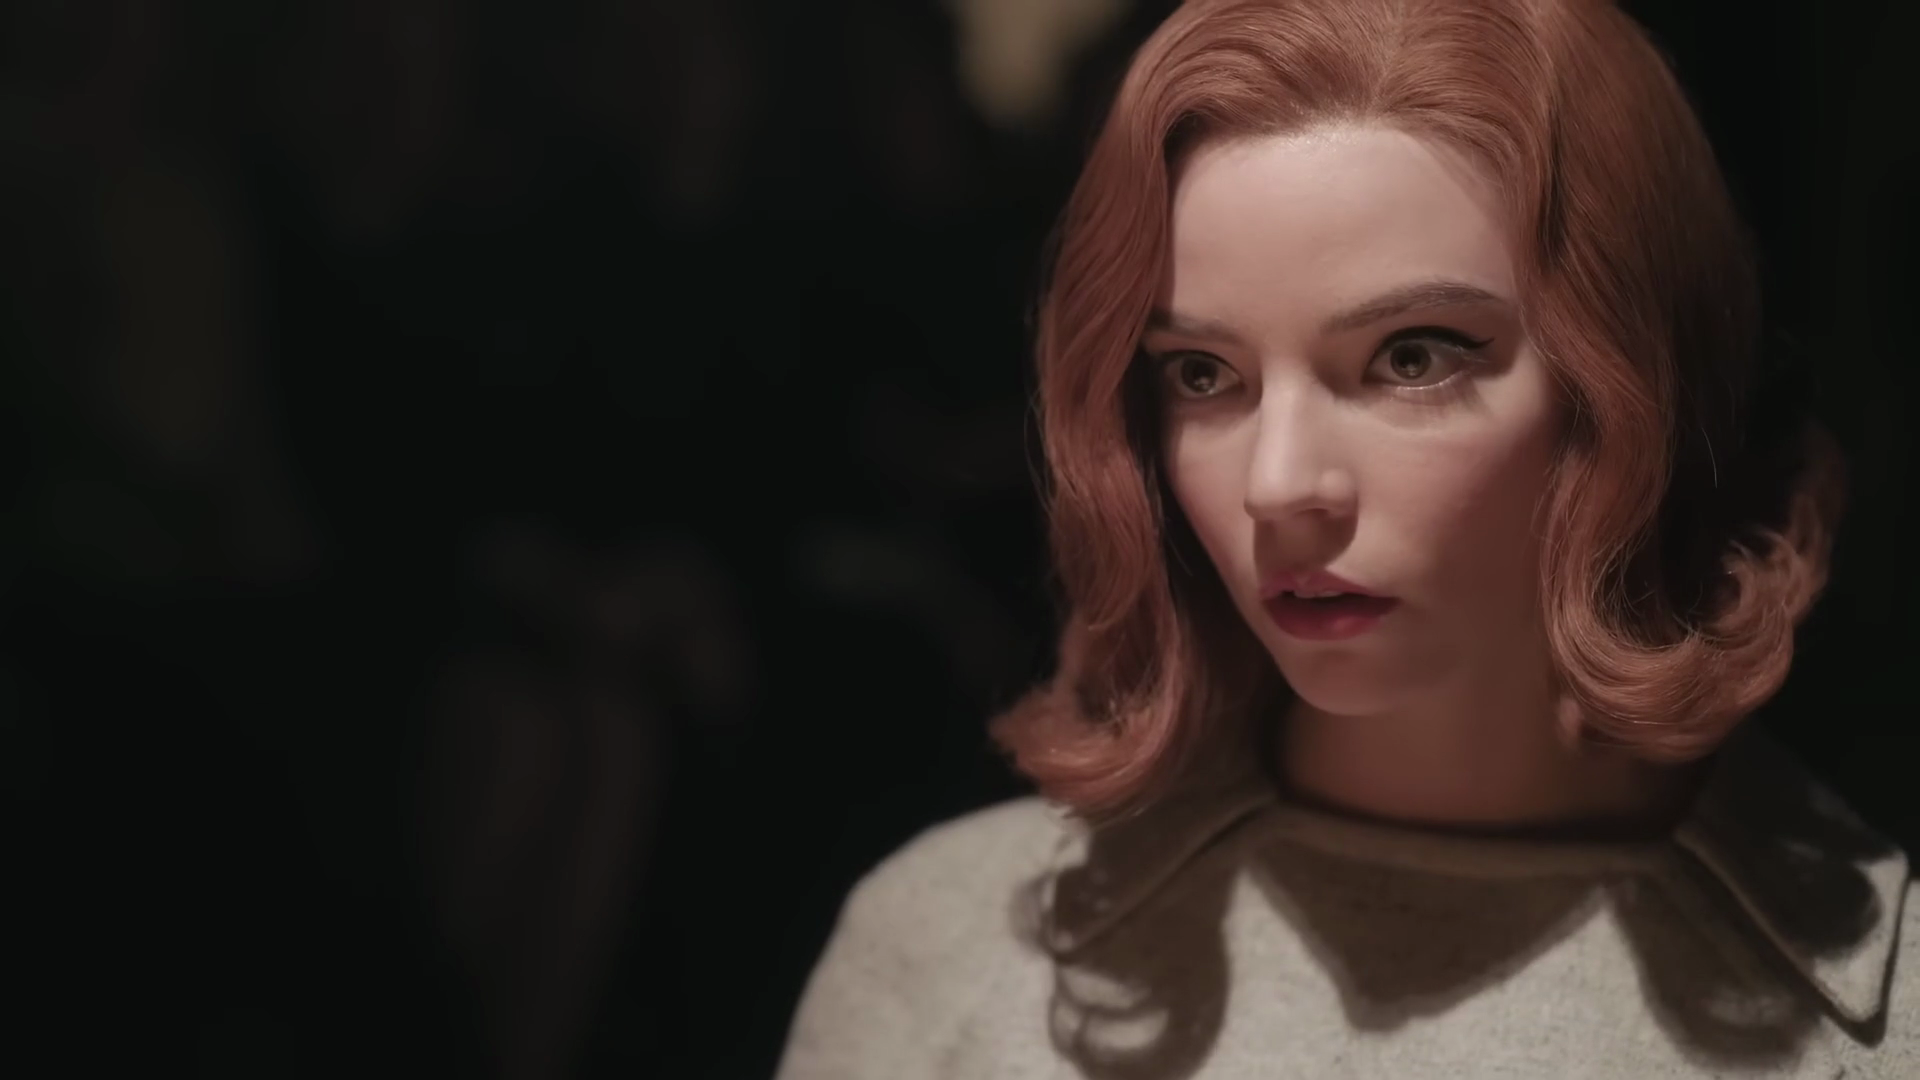

In [6]:
# Extract frame at a specific timestamp (in seconds) in a specific scene
# Here, I'm choosing the 11th second of the 9th scene
timestamp = 16.0  # Change this to your desired timestamp
query_frame = scenes.select(
    query_frame=scenes.video_segment.extract_frame(timestamp=timestamp)
).head()[0, 'query_frame']
query_frame

We can now find similar frames with a query:

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


pos                                       middle_frame  \
0    0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1    5  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2    2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3    4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                       video_segment  similarity  
0  /Users/alison-pxt/.pixeltable/media/d4730cf366...    0.993041  
1  /Users/alison-pxt/.pixeltable/media/d4730cf366...    0.759914  
2  /Users/alison-pxt/.pixeltable/media/d4730cf366...    0.748779  
3  /Users/alison-pxt/.pixeltable/media/d4730cf366...    0.712218
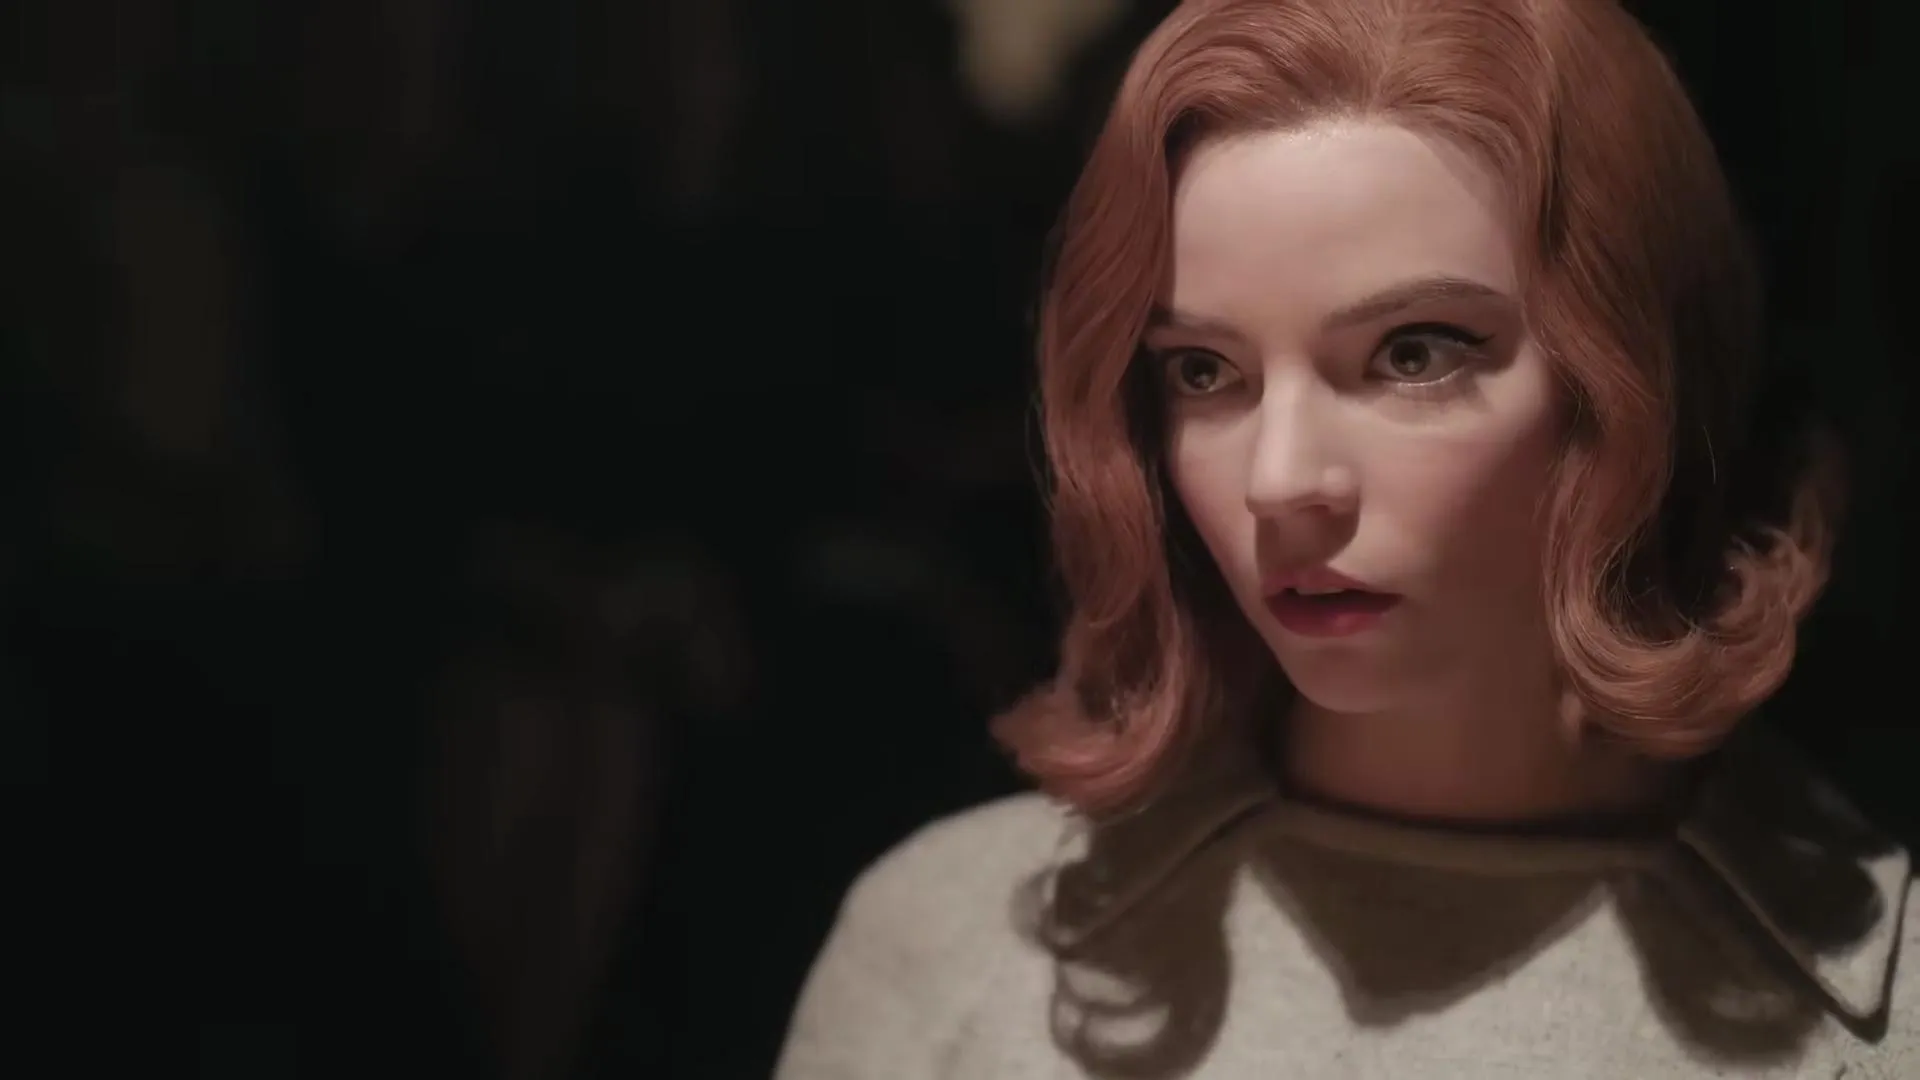
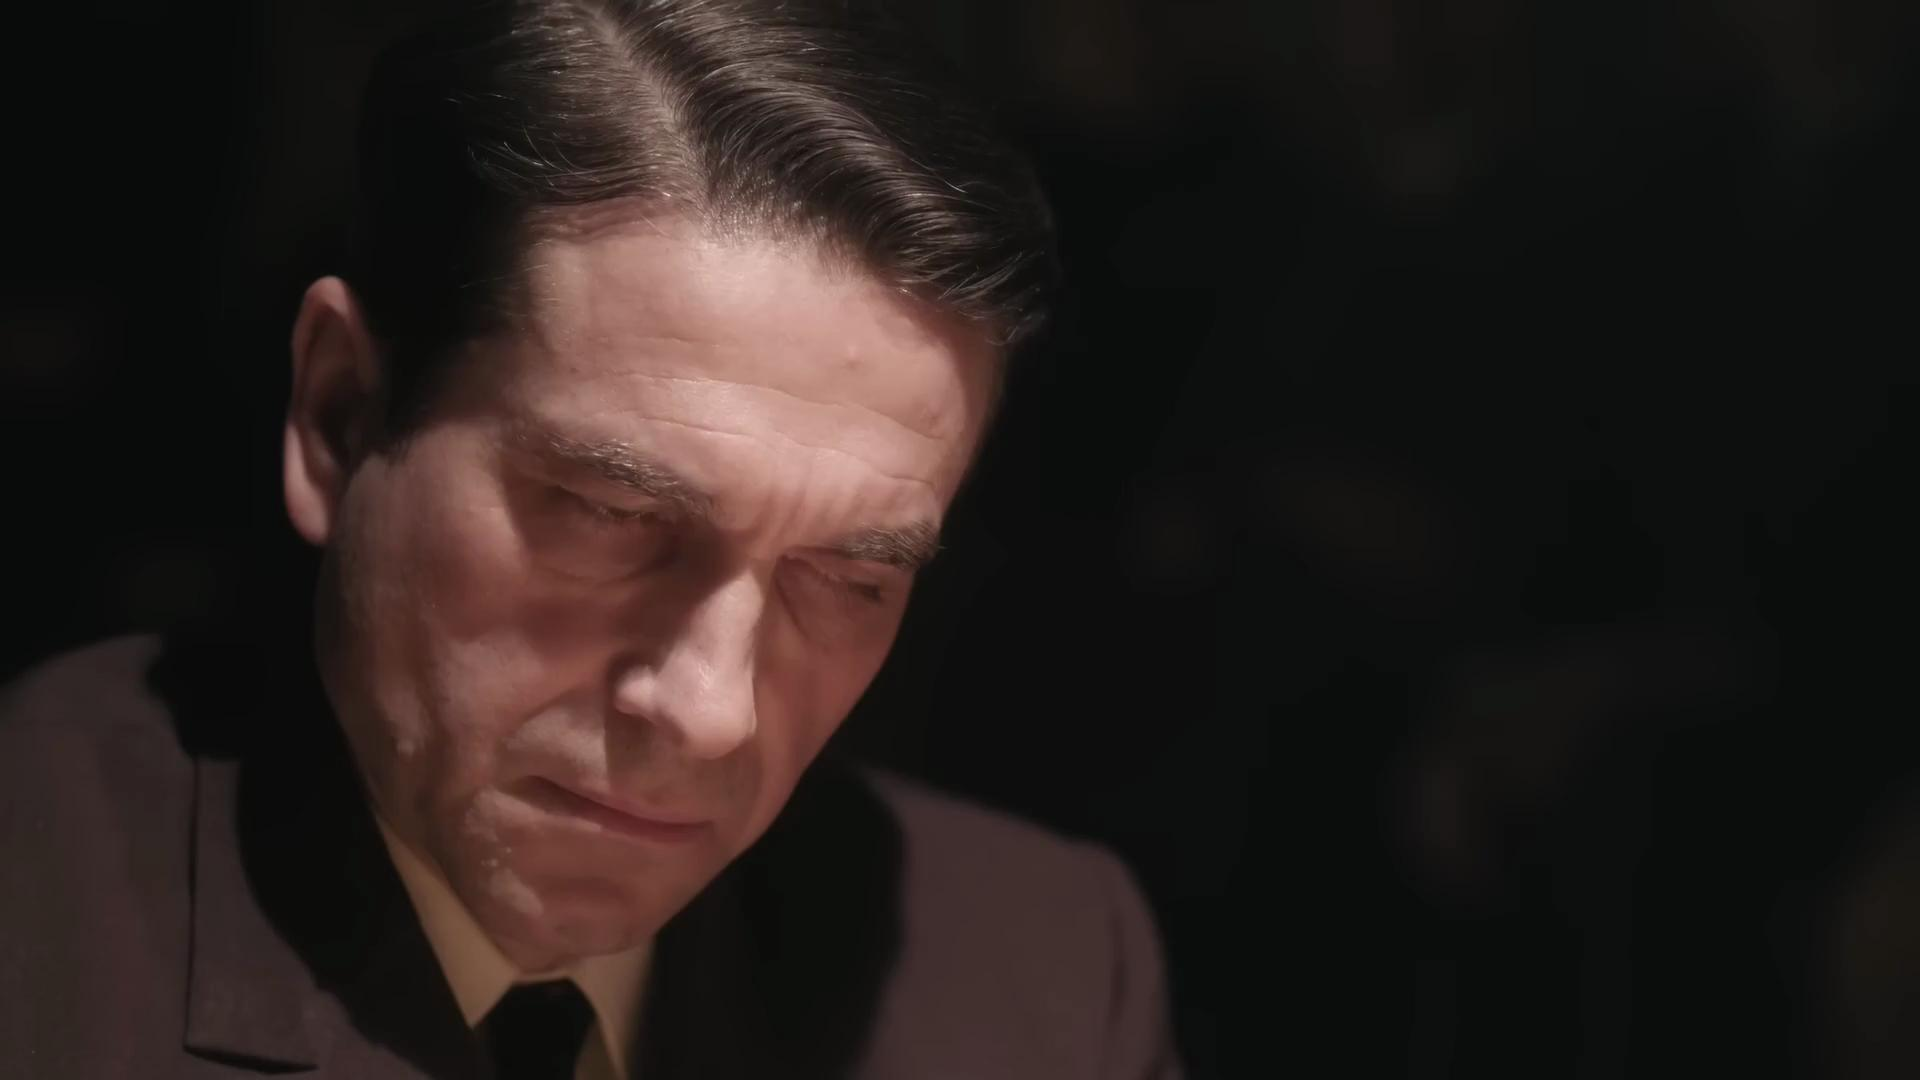
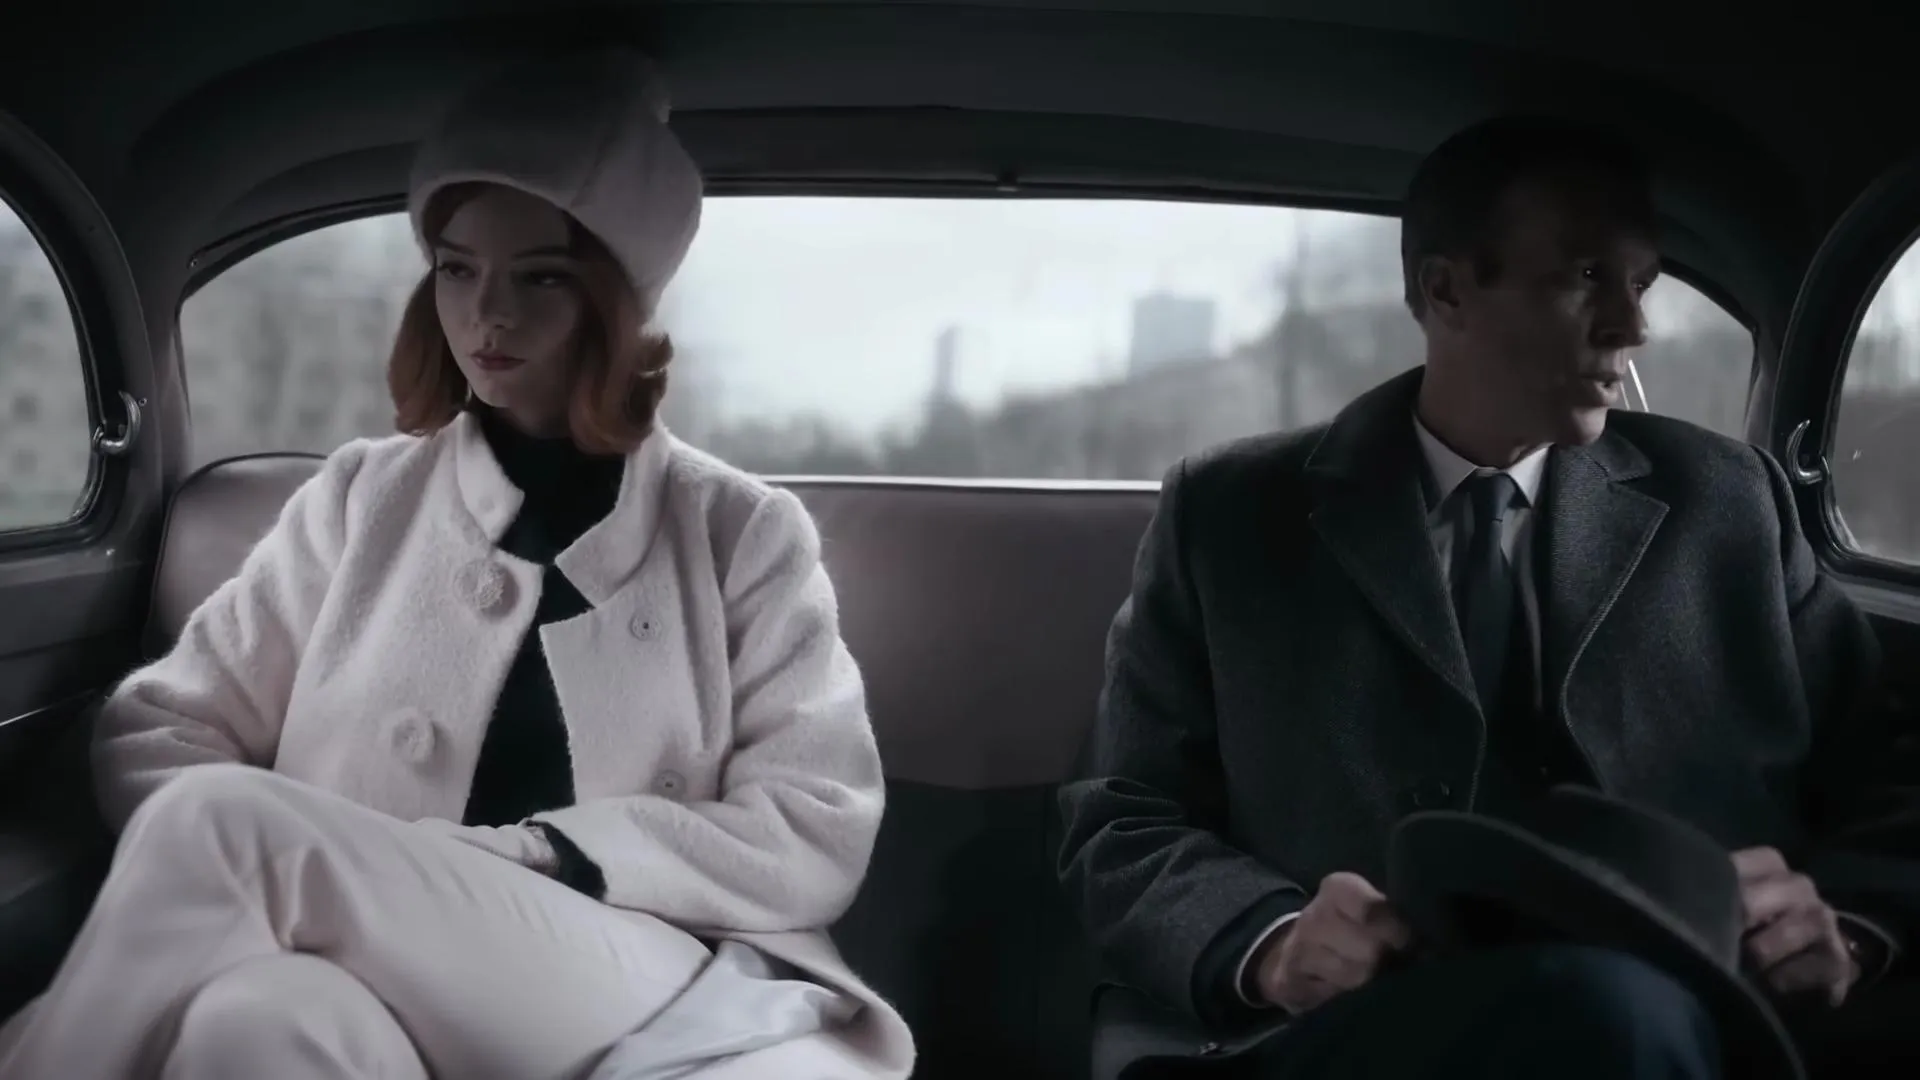
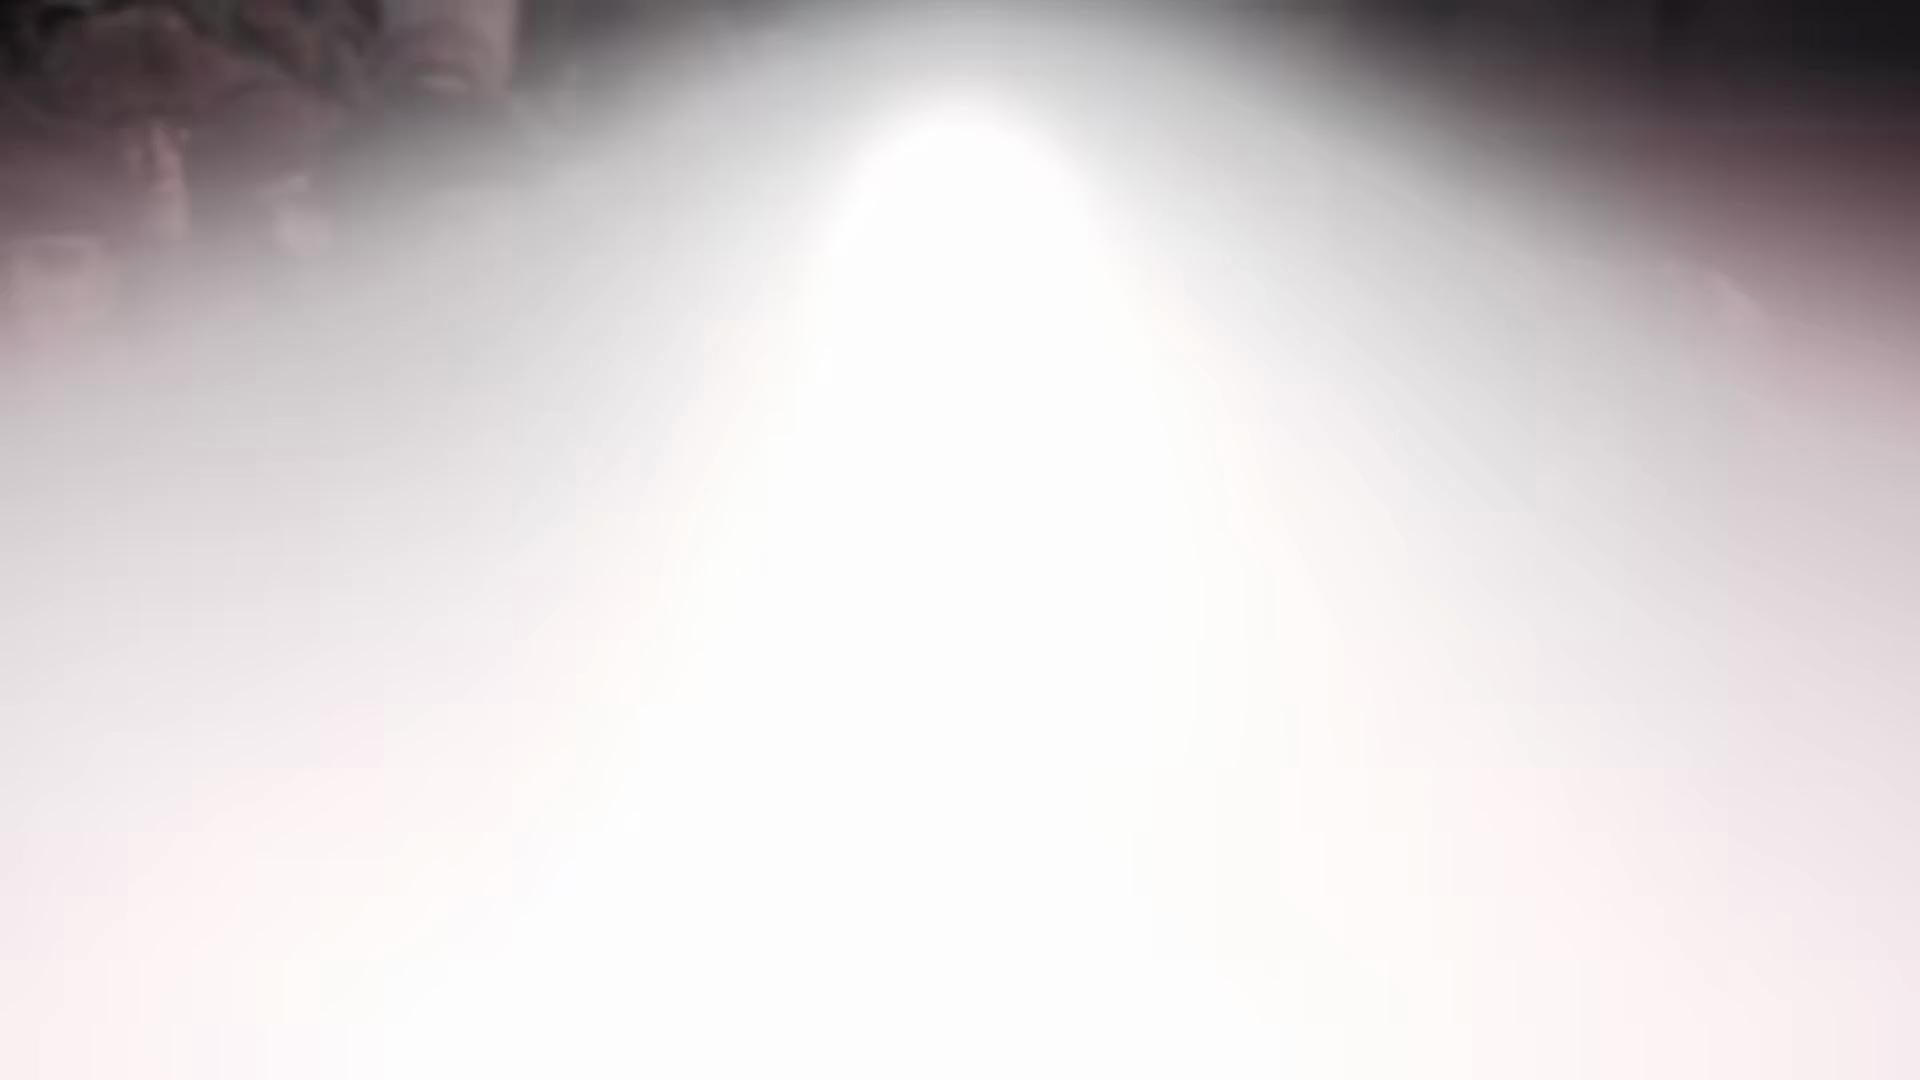
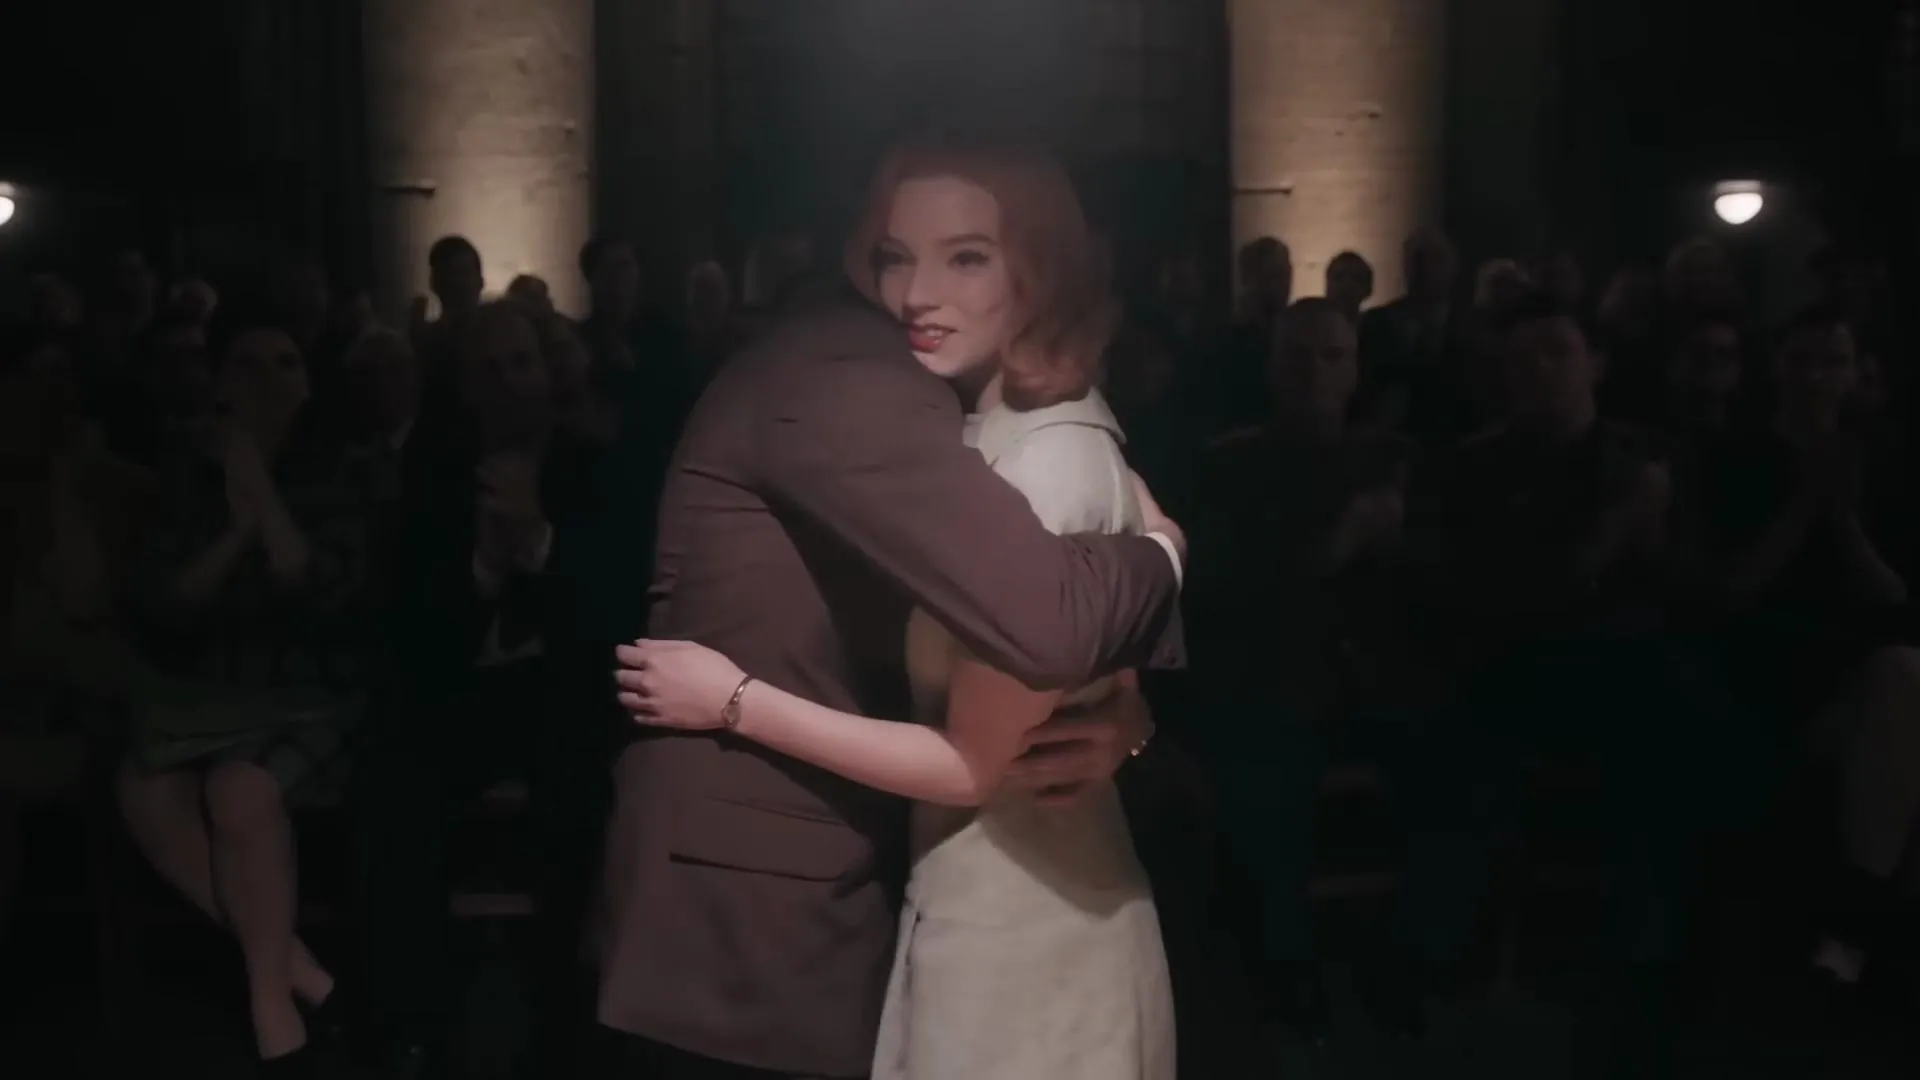
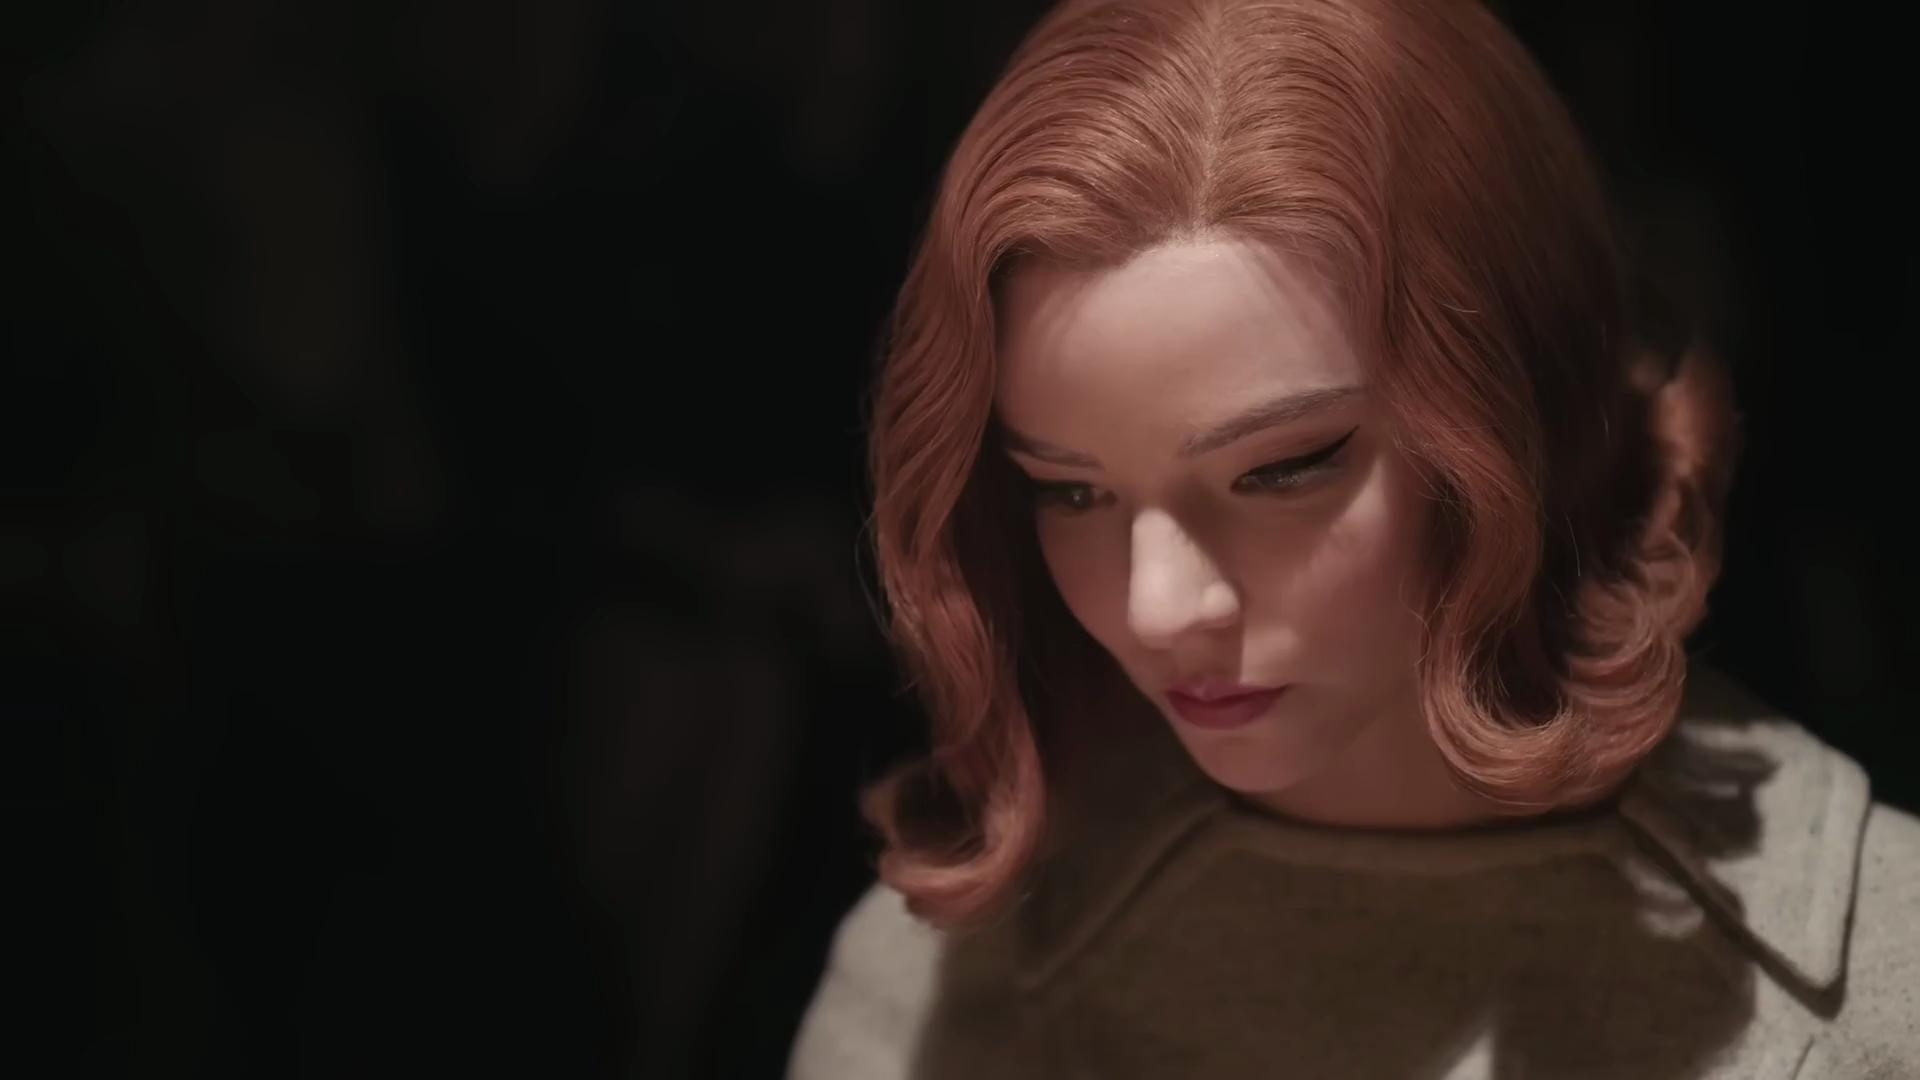
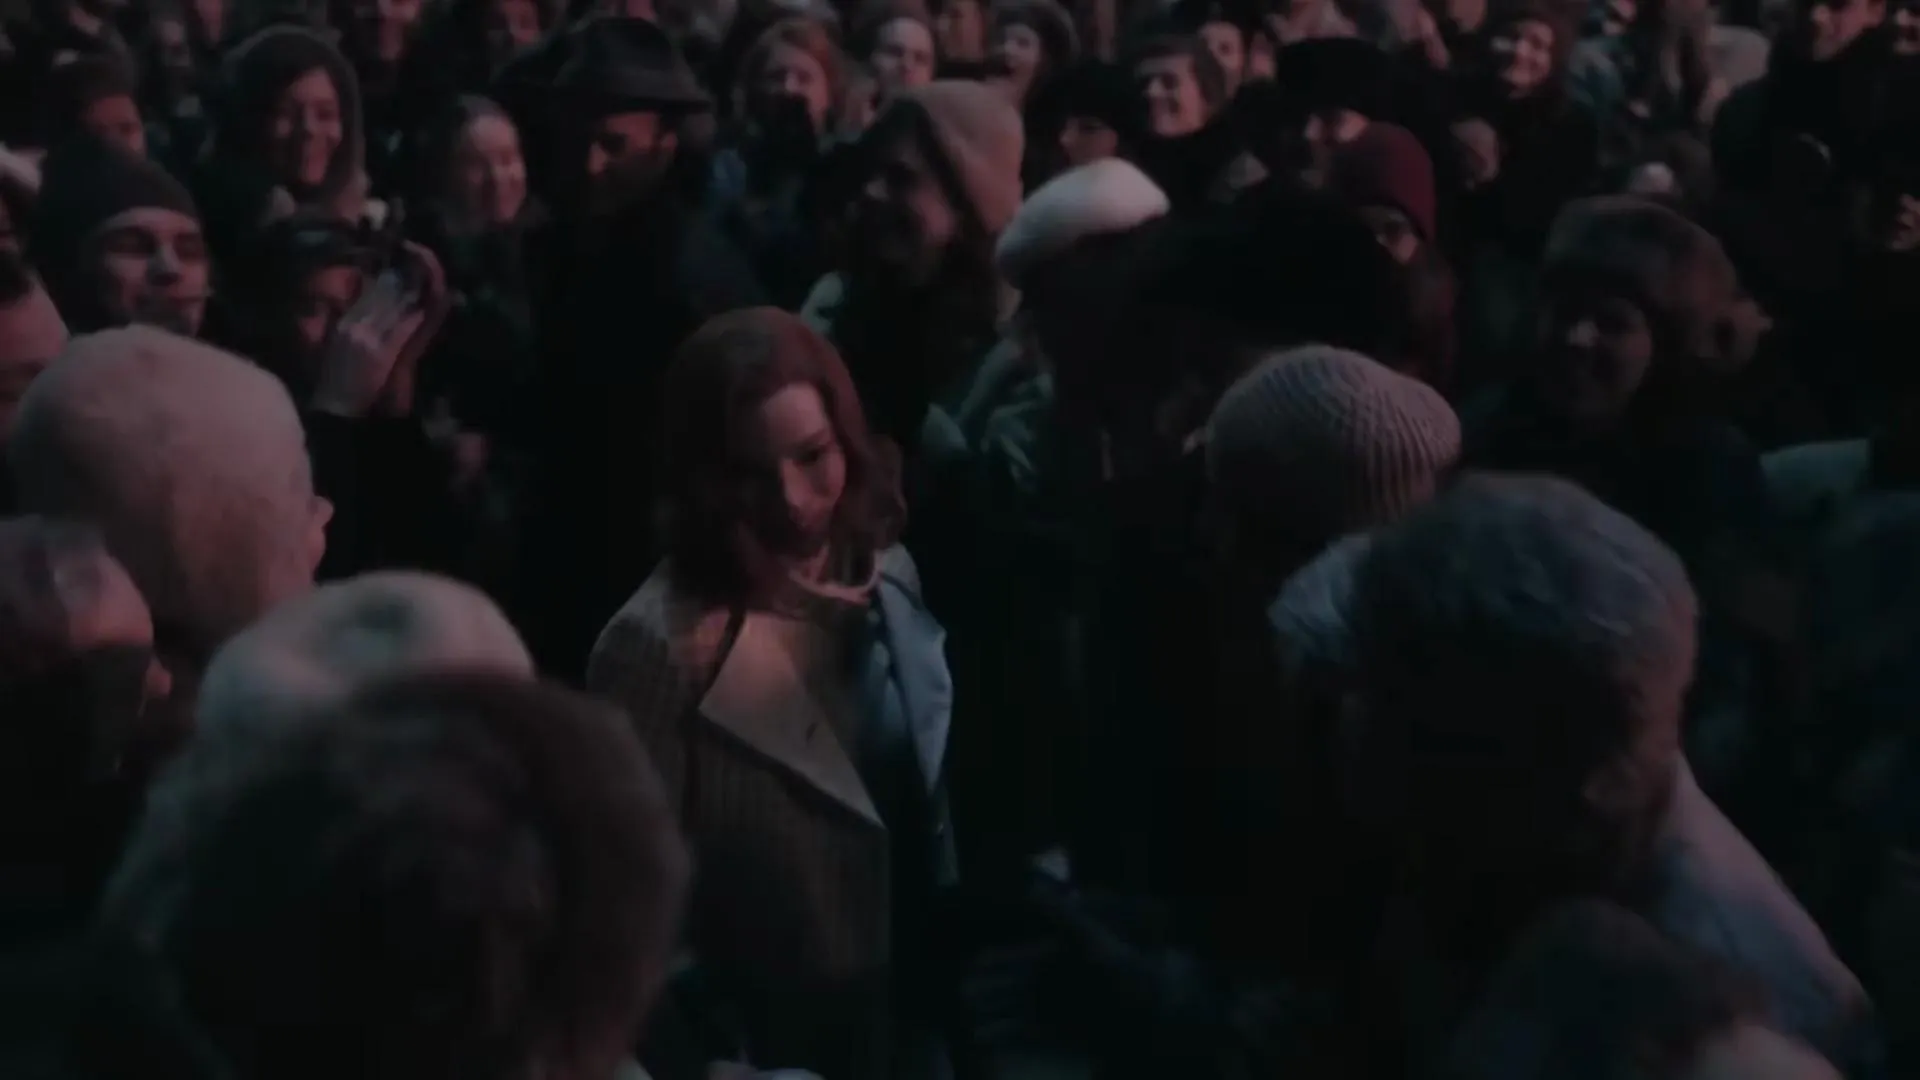
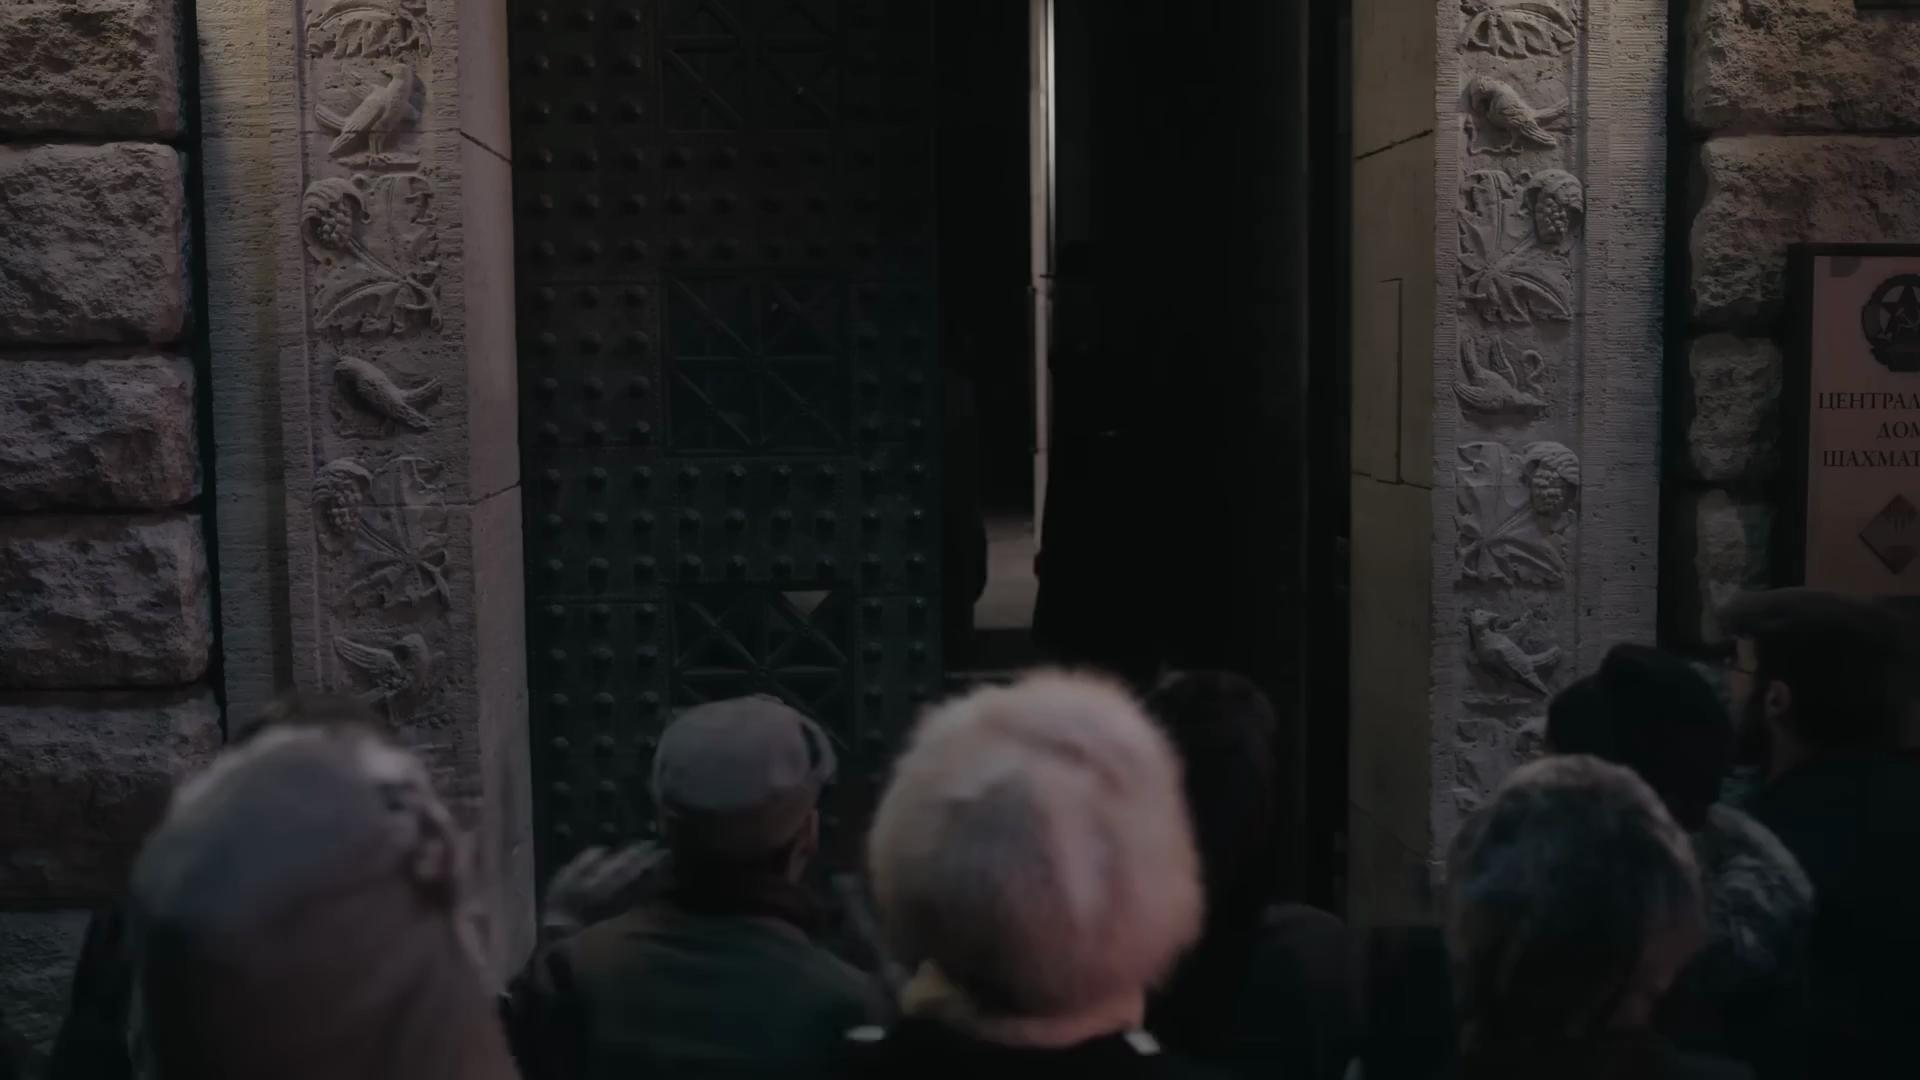

In [7]:
# Find top 4 similar frames using the embedding index
# The similarity() function will automatically use the index we created
# It expects the image directly, not the embedding
similar_frames = scenes.select(
    scenes.pos,
    scenes.middle_frame,
    scenes.video_segment, # We are adding this back in!
    similarity=scenes.middle_frame.similarity(query_frame)
).order_by(
    scenes.middle_frame.similarity(query_frame), 
    asc=False
).limit(4).collect()

similar_frames

## 01 - Find similar scenes and create clips

Now that we've found visually similar frames using semantic search, let's create a scene reel by extracting video clips from those scenes.

The workflow:
1. **Similar frames** → We already identified the top N most visually similar frames using embedding-based similarity search
2. **Store scenes** → Create a table to hold the selected scenes with their video segments
3. **Extract clips** → Pull short clips from the middle of each scene
4. **Concatenate** → Combine all clips into a single scene reel

This approach lets us compose new content by finding scenes with similar visual characteristics and stitching them together into a video sequence.


**Create a table to store the selected scenes**

We'll create a new table with three columns: the scene position, the middle frame image, and the full video segment.


In [8]:
# Create a table to store scene middle frames and scene clips
sim_scenes = pxt.create_table(
    'similar-scenes',
    schema={
        'scene_pos': pxt.Int,  # Position of the scene in the original scenes table
        'middle_frame': pxt.Image,  # The middle frame from the scene
        'video_segment': pxt.Video,  # The video segment from the scene
    },
    if_exists='replace'
)

Created table 'similar-scenes'.


In [9]:
sim_scenes

table 'similar-scenes'

    Column Name   Type Computed With
      scene_pos    Int              
   middle_frame  Image              
  video_segment  Video

**Insert the similar scenes into the table**

Now we'll populate the table with the 4 similar scenes we found earlier:


In [10]:
# Insert the selected scenes with their middle frames and prompts
sim_scenes.insert([{
    'scene_pos': row['pos'],
    'middle_frame': row['middle_frame'],
    'video_segment': row['video_segment']
} for row in similar_frames])

Inserting rows into `similar-scenes`: 4 rows [00:00, 850.90 rows/s]
Inserted 4 rows with 0 errors.


4 rows inserted, 16 values computed.

**Extract 6-second clips from the middle of each scene**

Add a computed column that extracts a 6-second clip centered on the middle of each scene (3 seconds before and after the midpoint):


In [11]:
# take a 6-second clip from the middle of each scene
sim_scenes.add_computed_column(
    middle_clip=sim_scenes.video_segment.clip(
        start_time=sim_scenes.video_segment.get_duration() / 2.0 - 3.0,
        end_time=sim_scenes.video_segment.get_duration() / 2.0 + 3.0
    ),
    if_exists='replace'
)

Added 4 column values with 0 errors.


4 rows updated, 4 values computed.

Let's view the results to see our selected scenes with their middle frames and 6-second clips:

scene_pos                                       middle_frame  \
0          0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1          5  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2          2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3          4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                         middle_clip  
0  /Users/alison-pxt/.pixeltable/media/474d67ee44...  
1  /Users/alison-pxt/.pixeltable/media/474d67ee44...  
2  /Users/alison-pxt/.pixeltable/media/474d67ee44...  
3  /Users/alison-pxt/.pixeltable/media/474d67ee44...
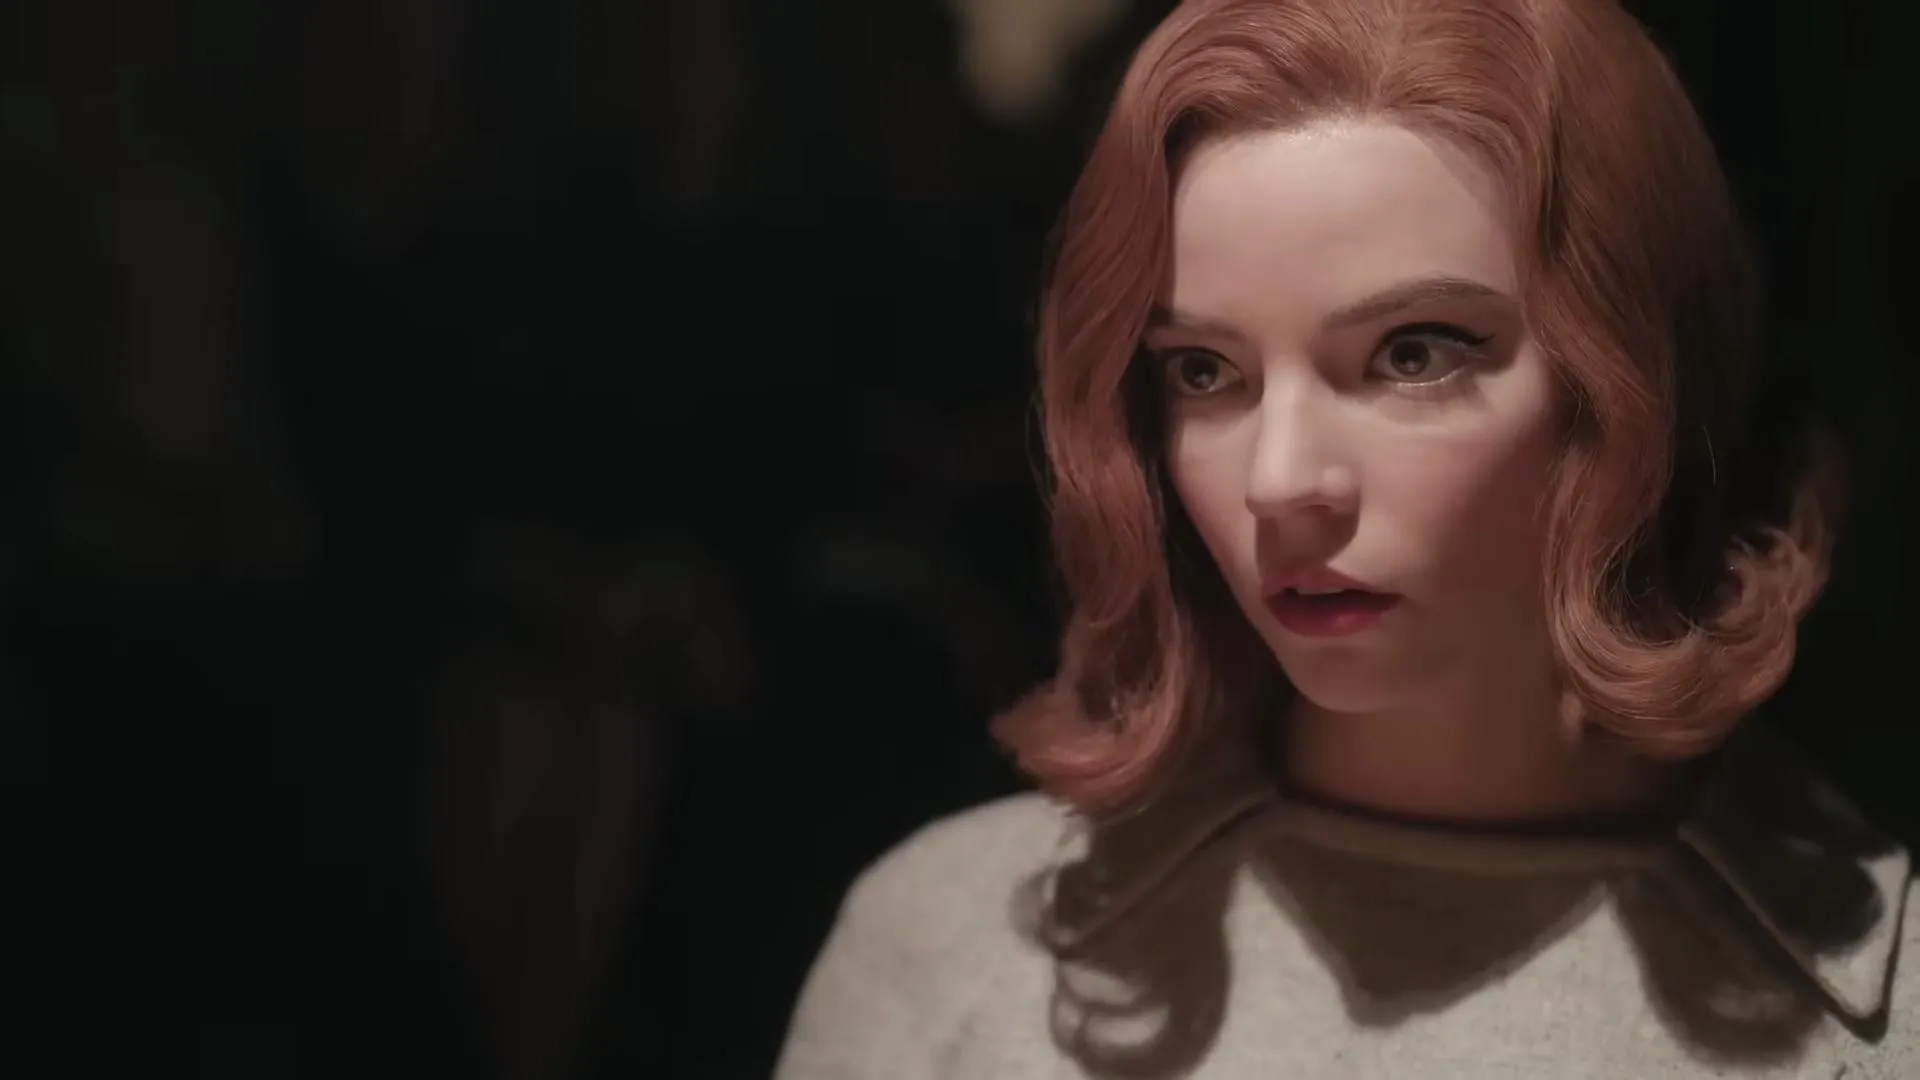
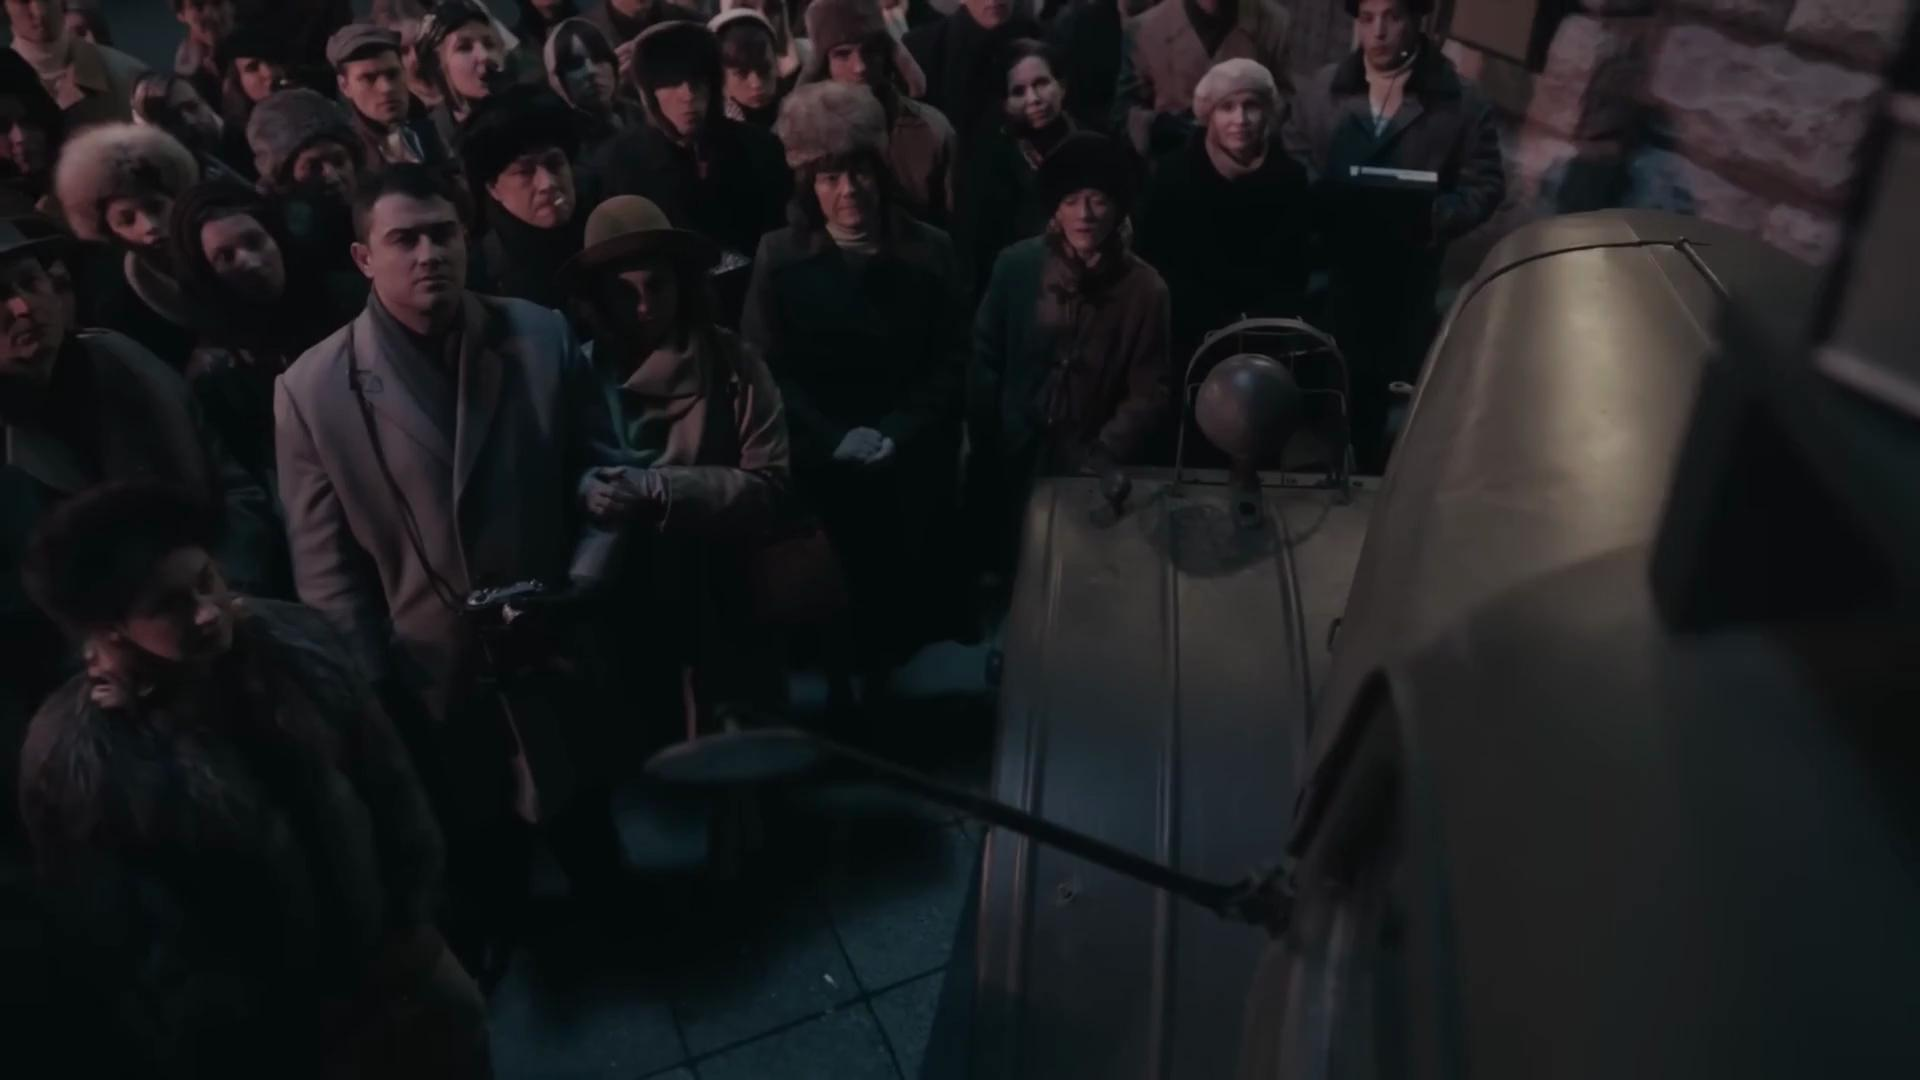
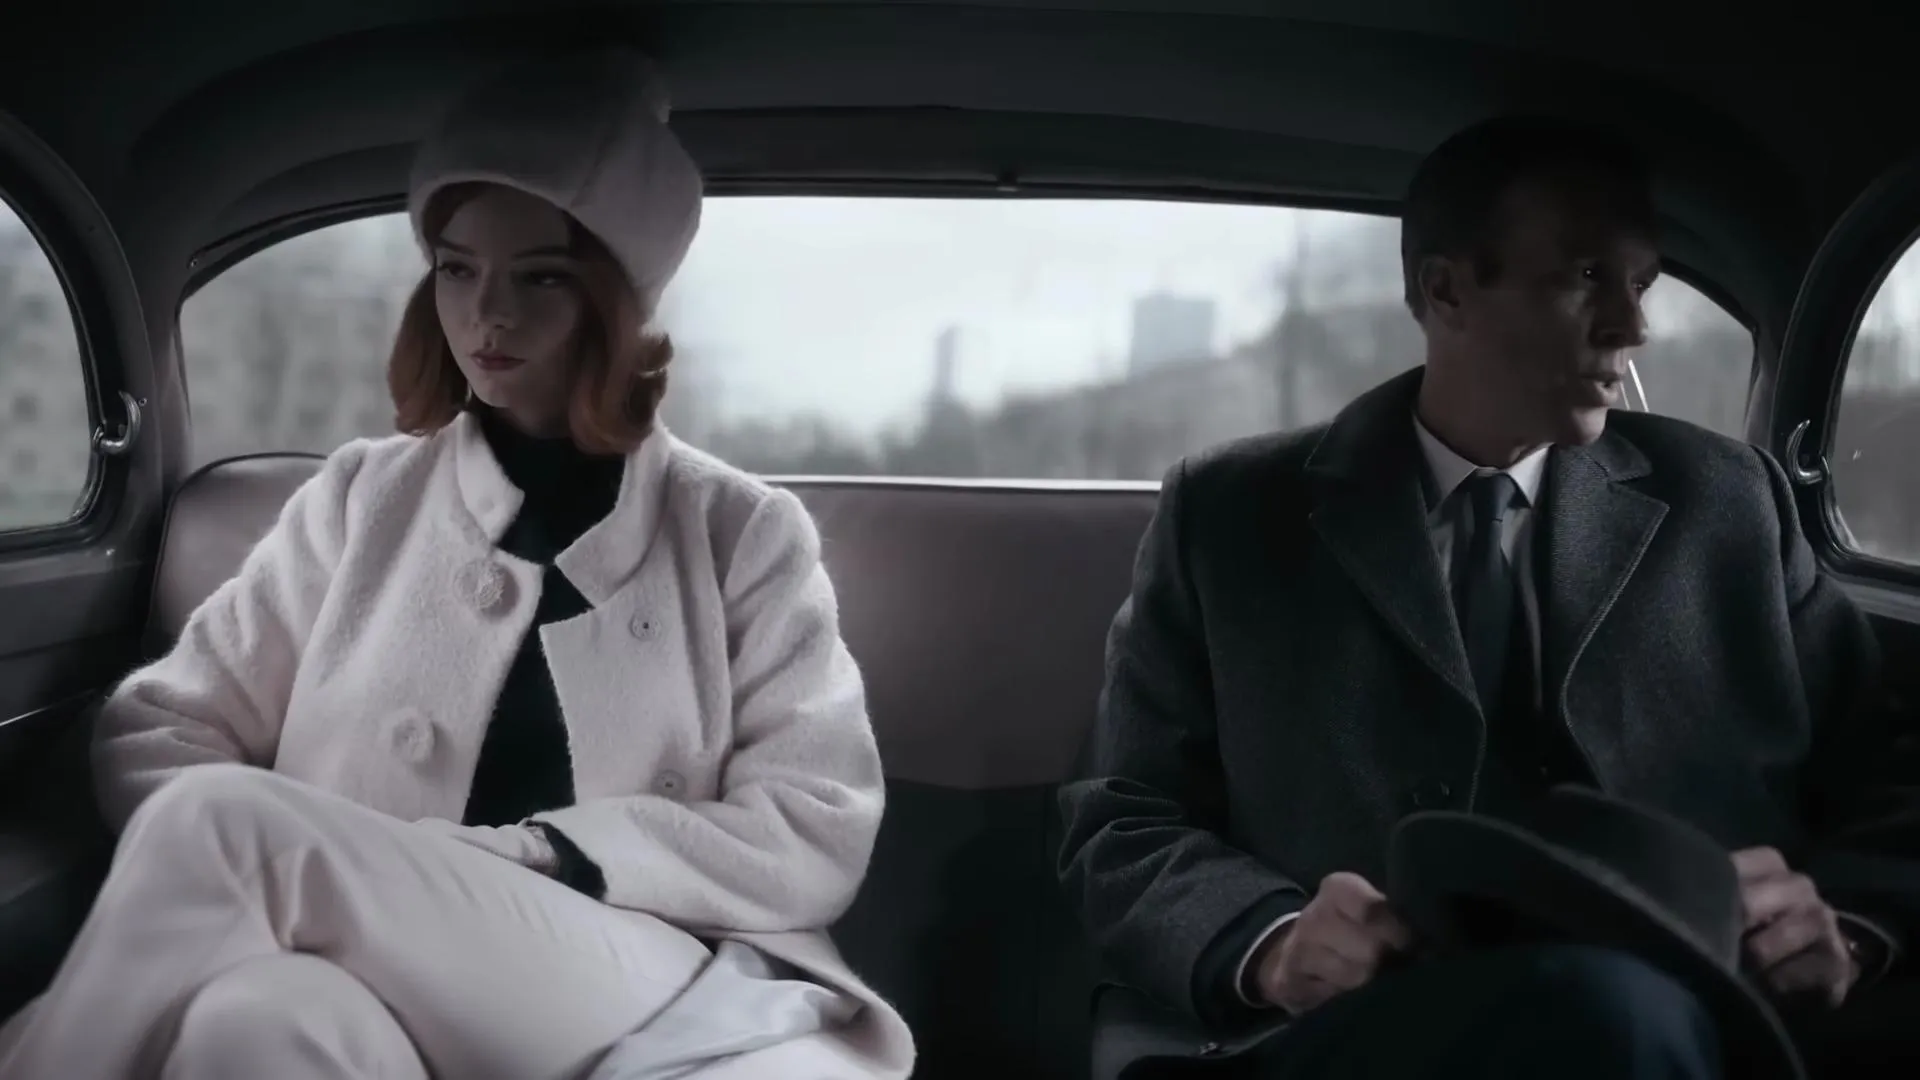
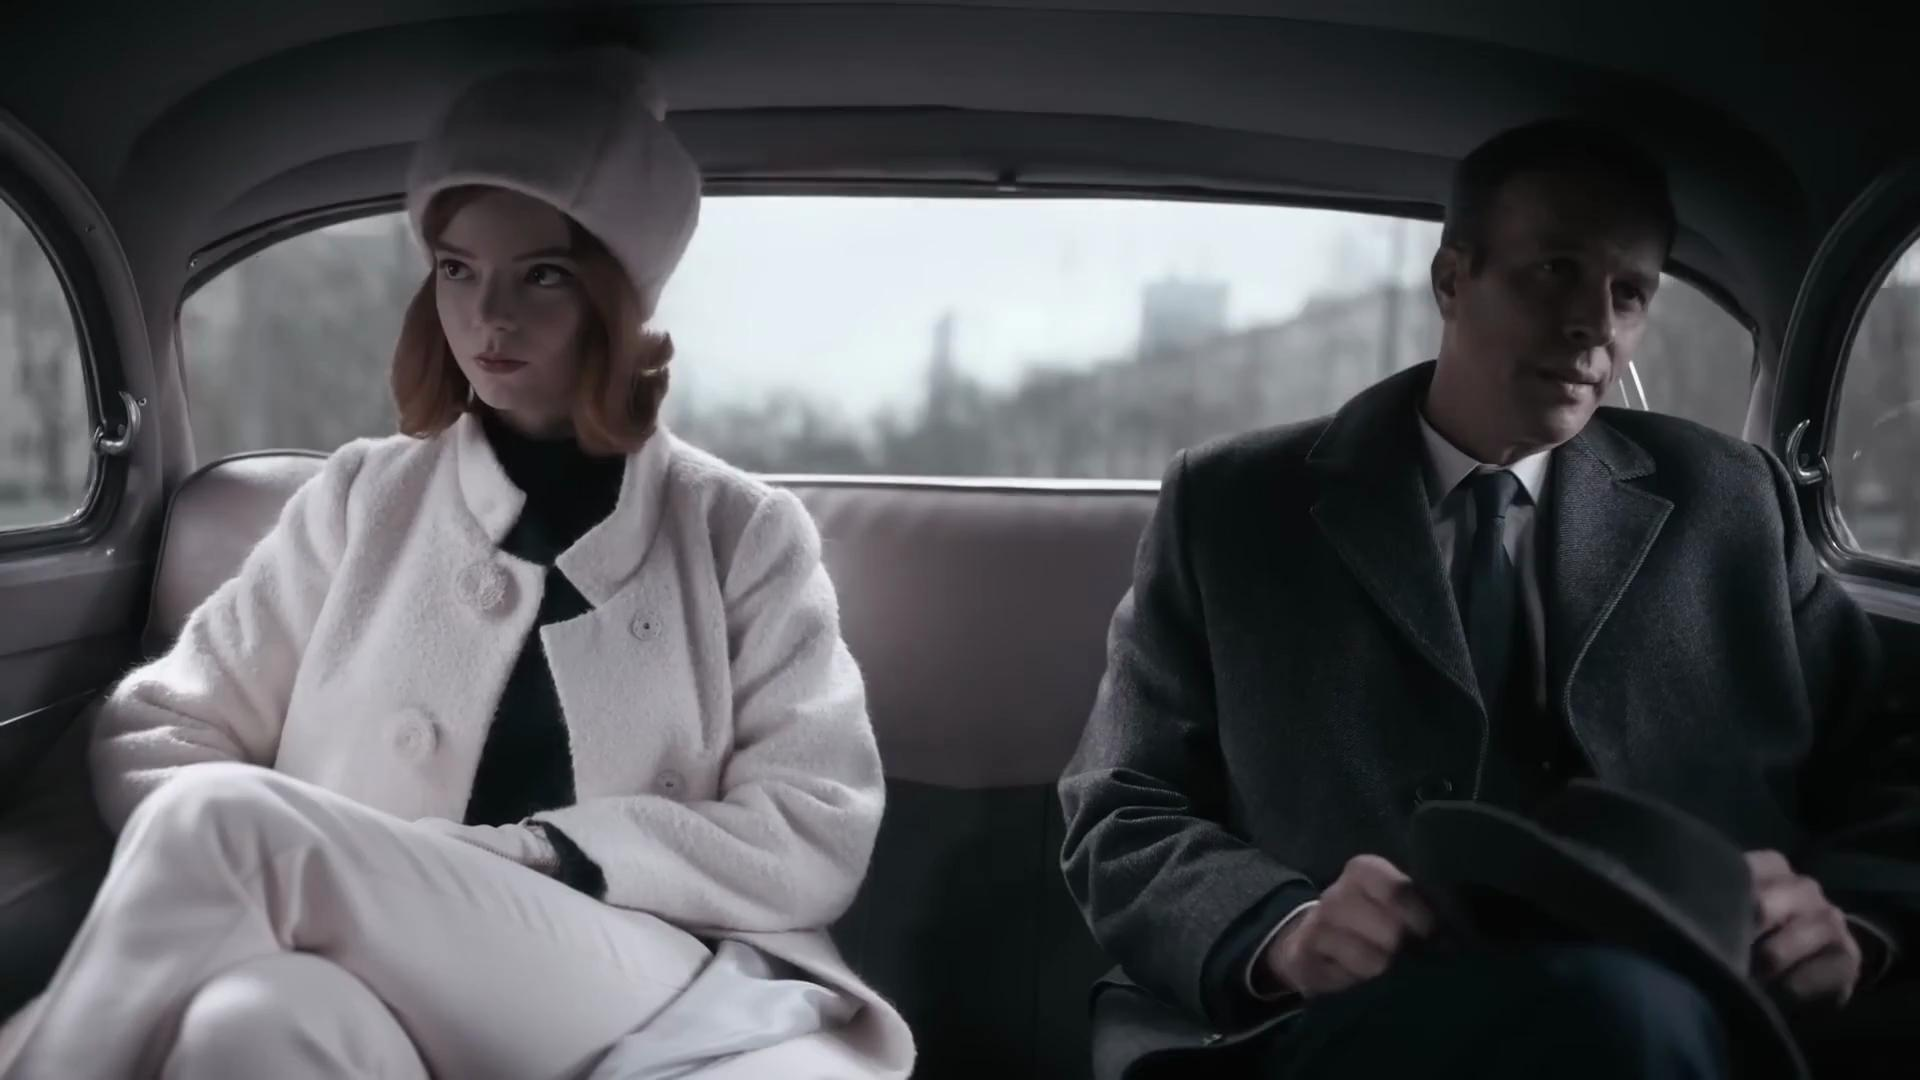
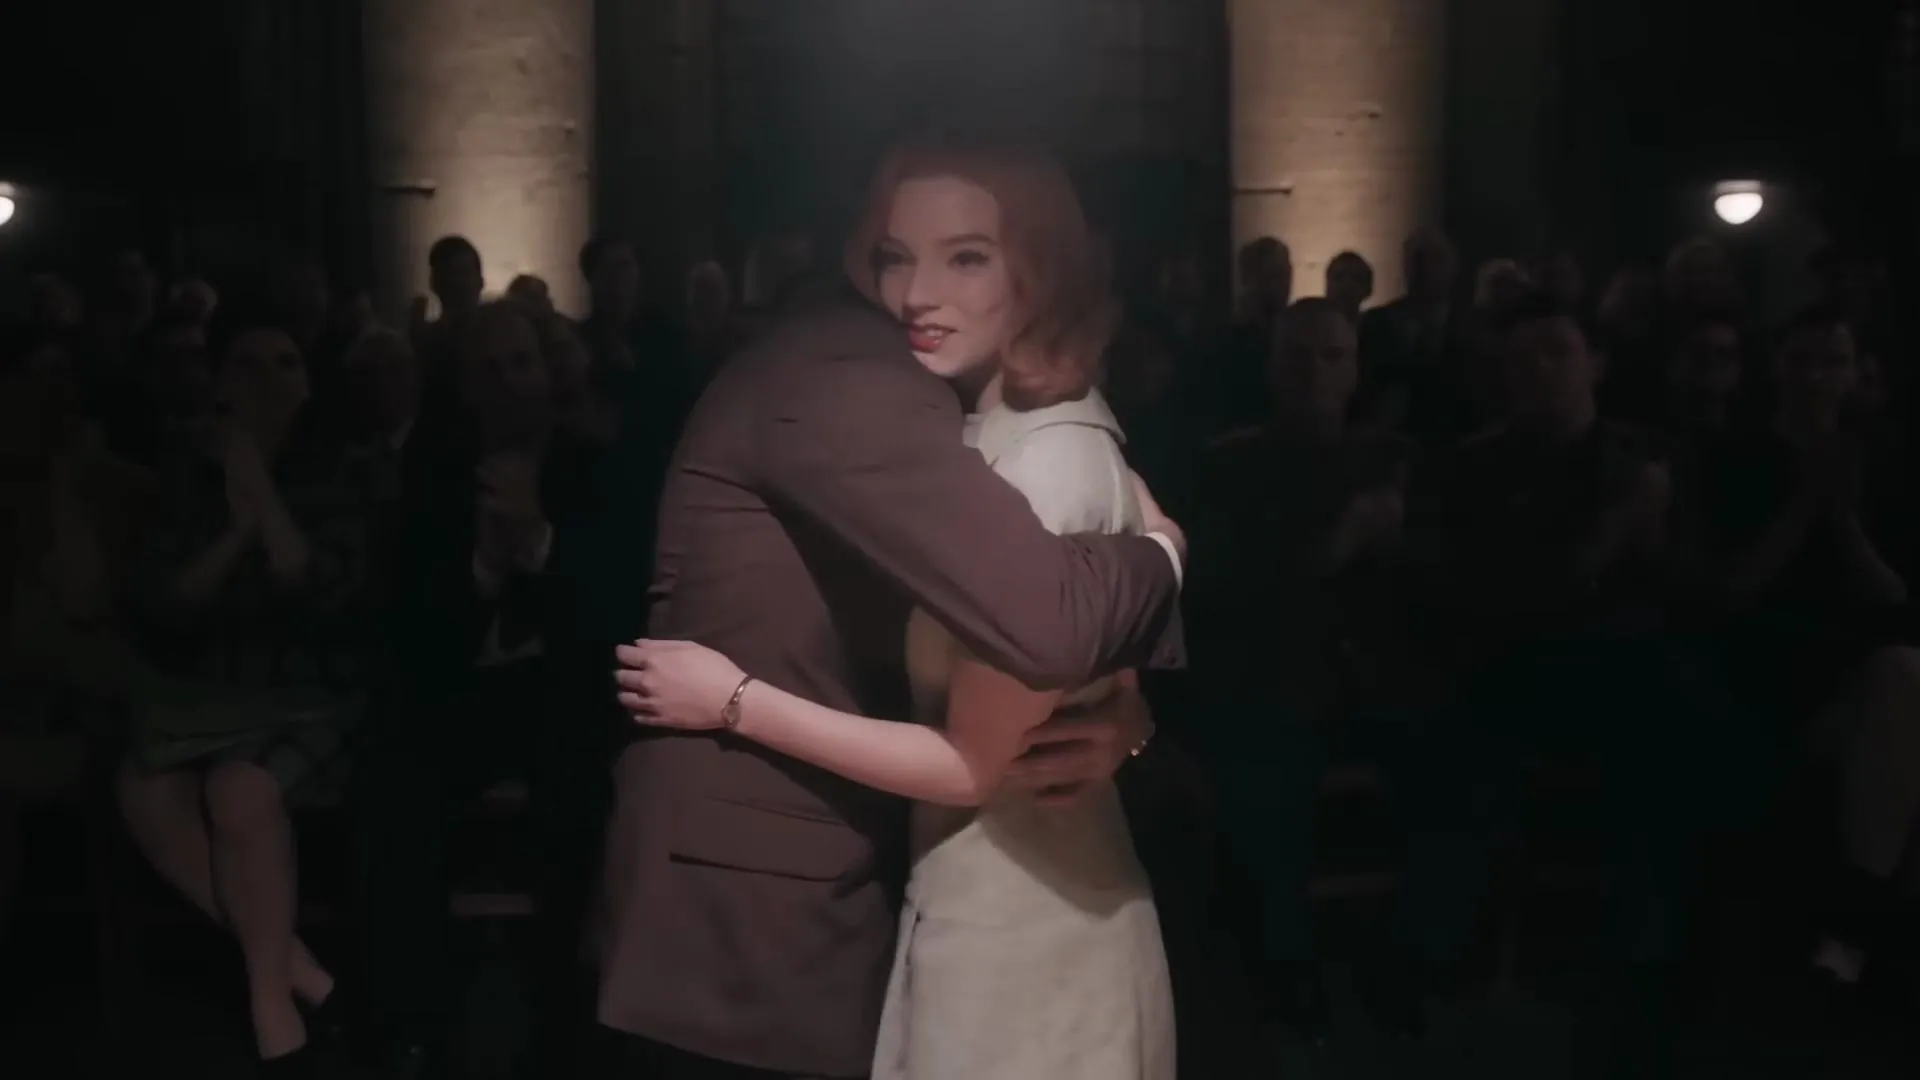
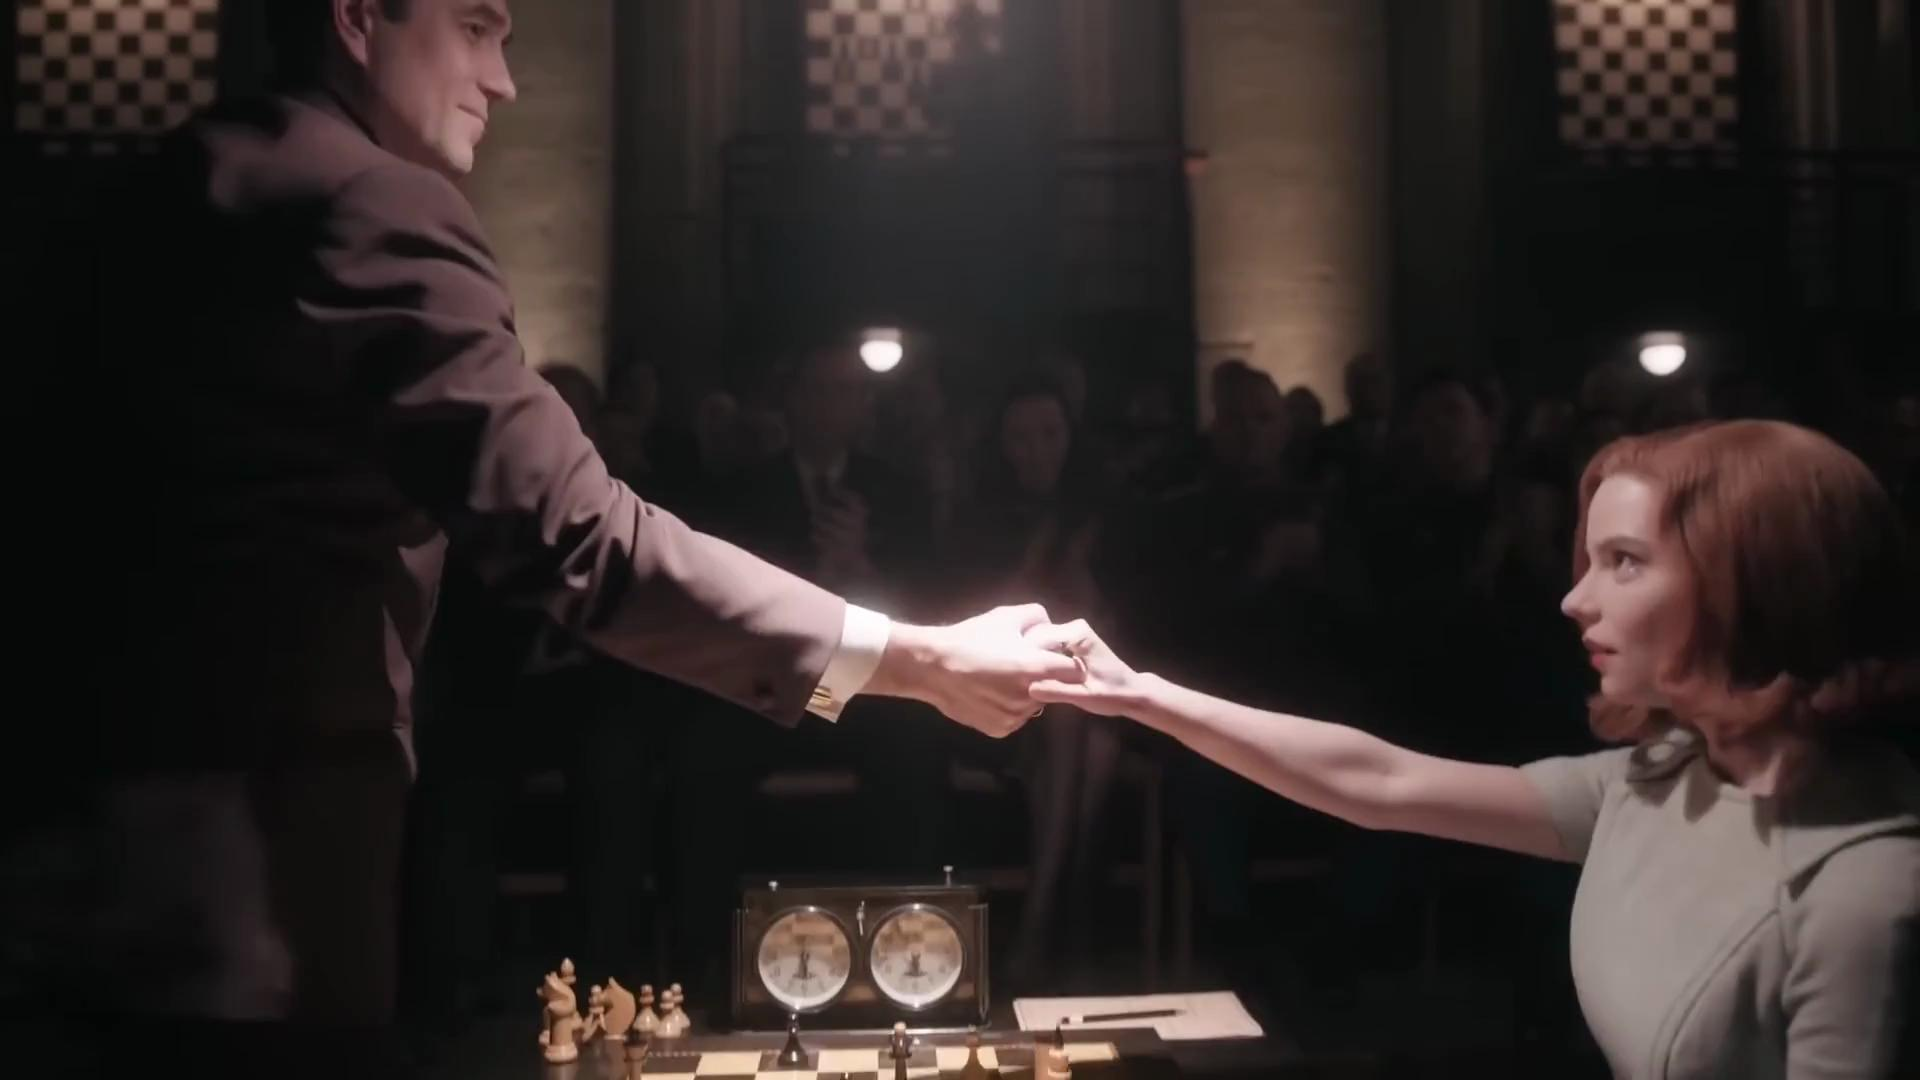
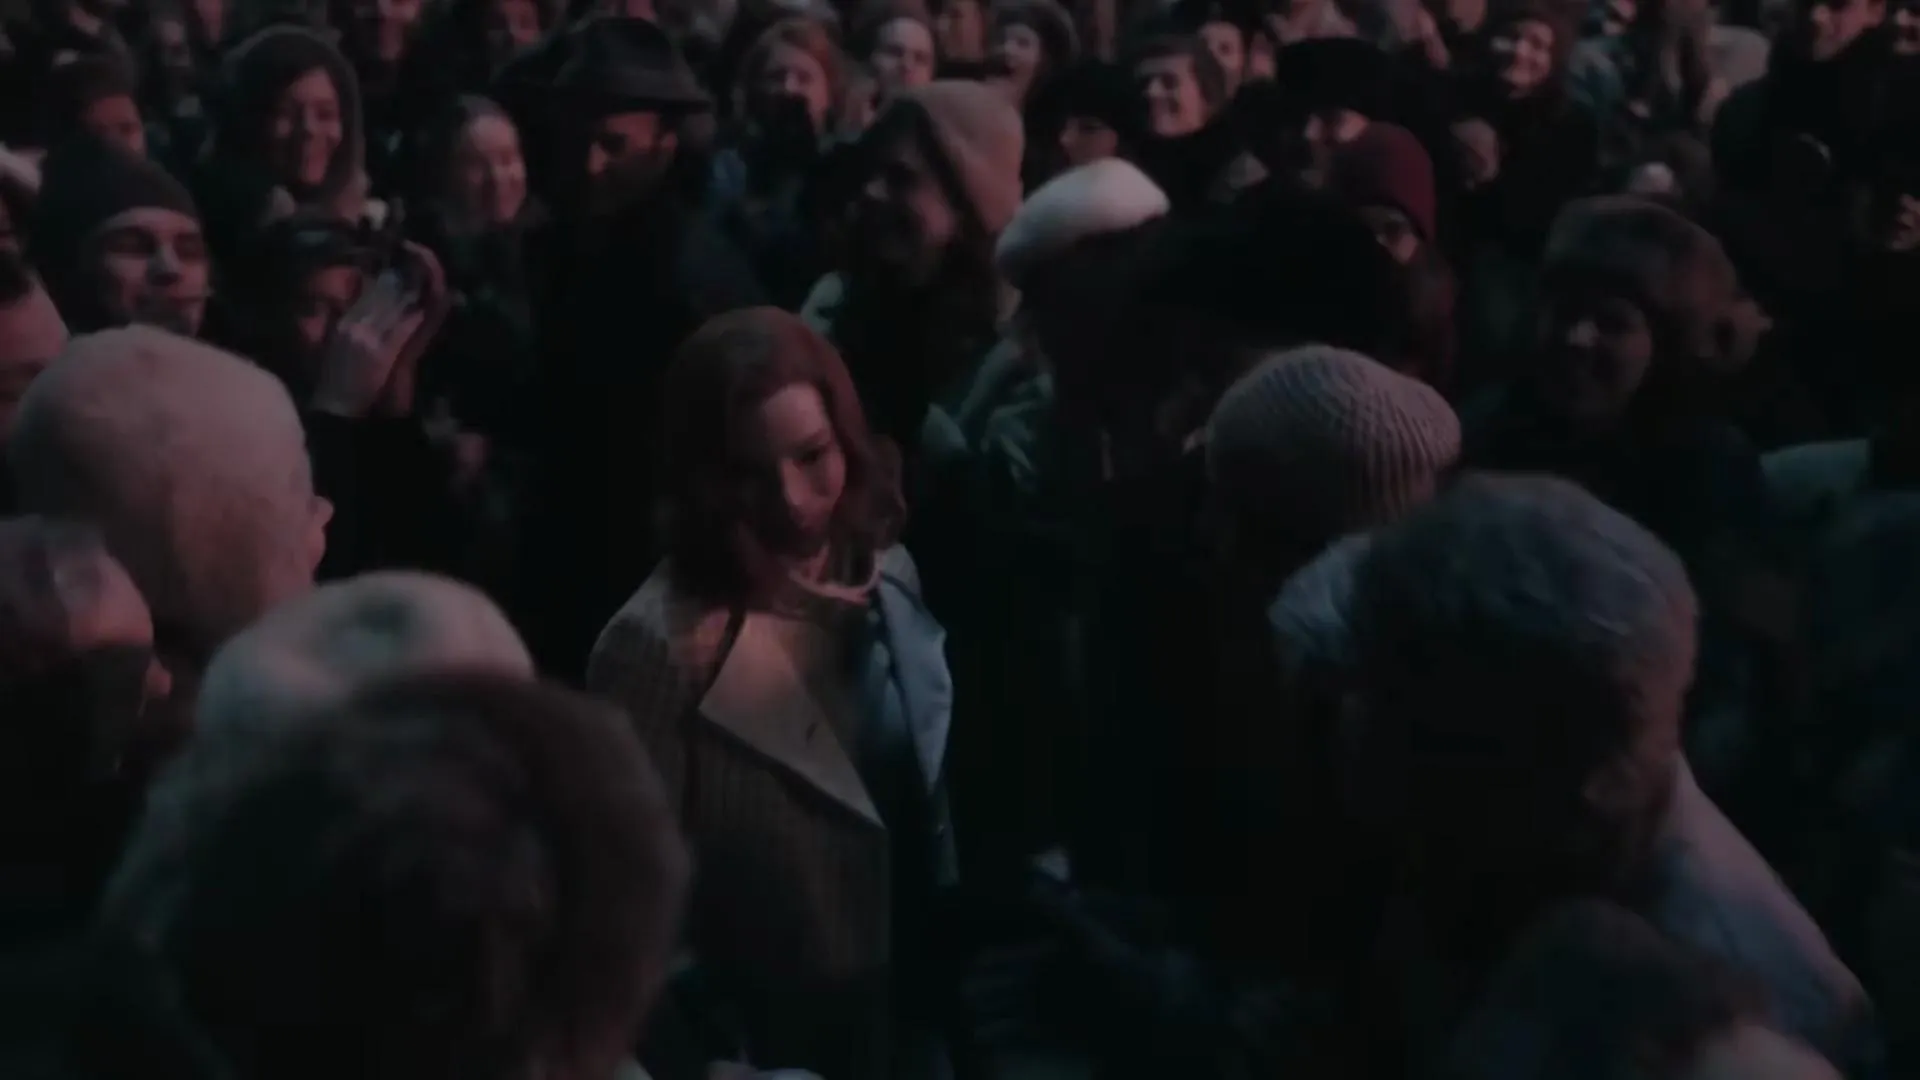
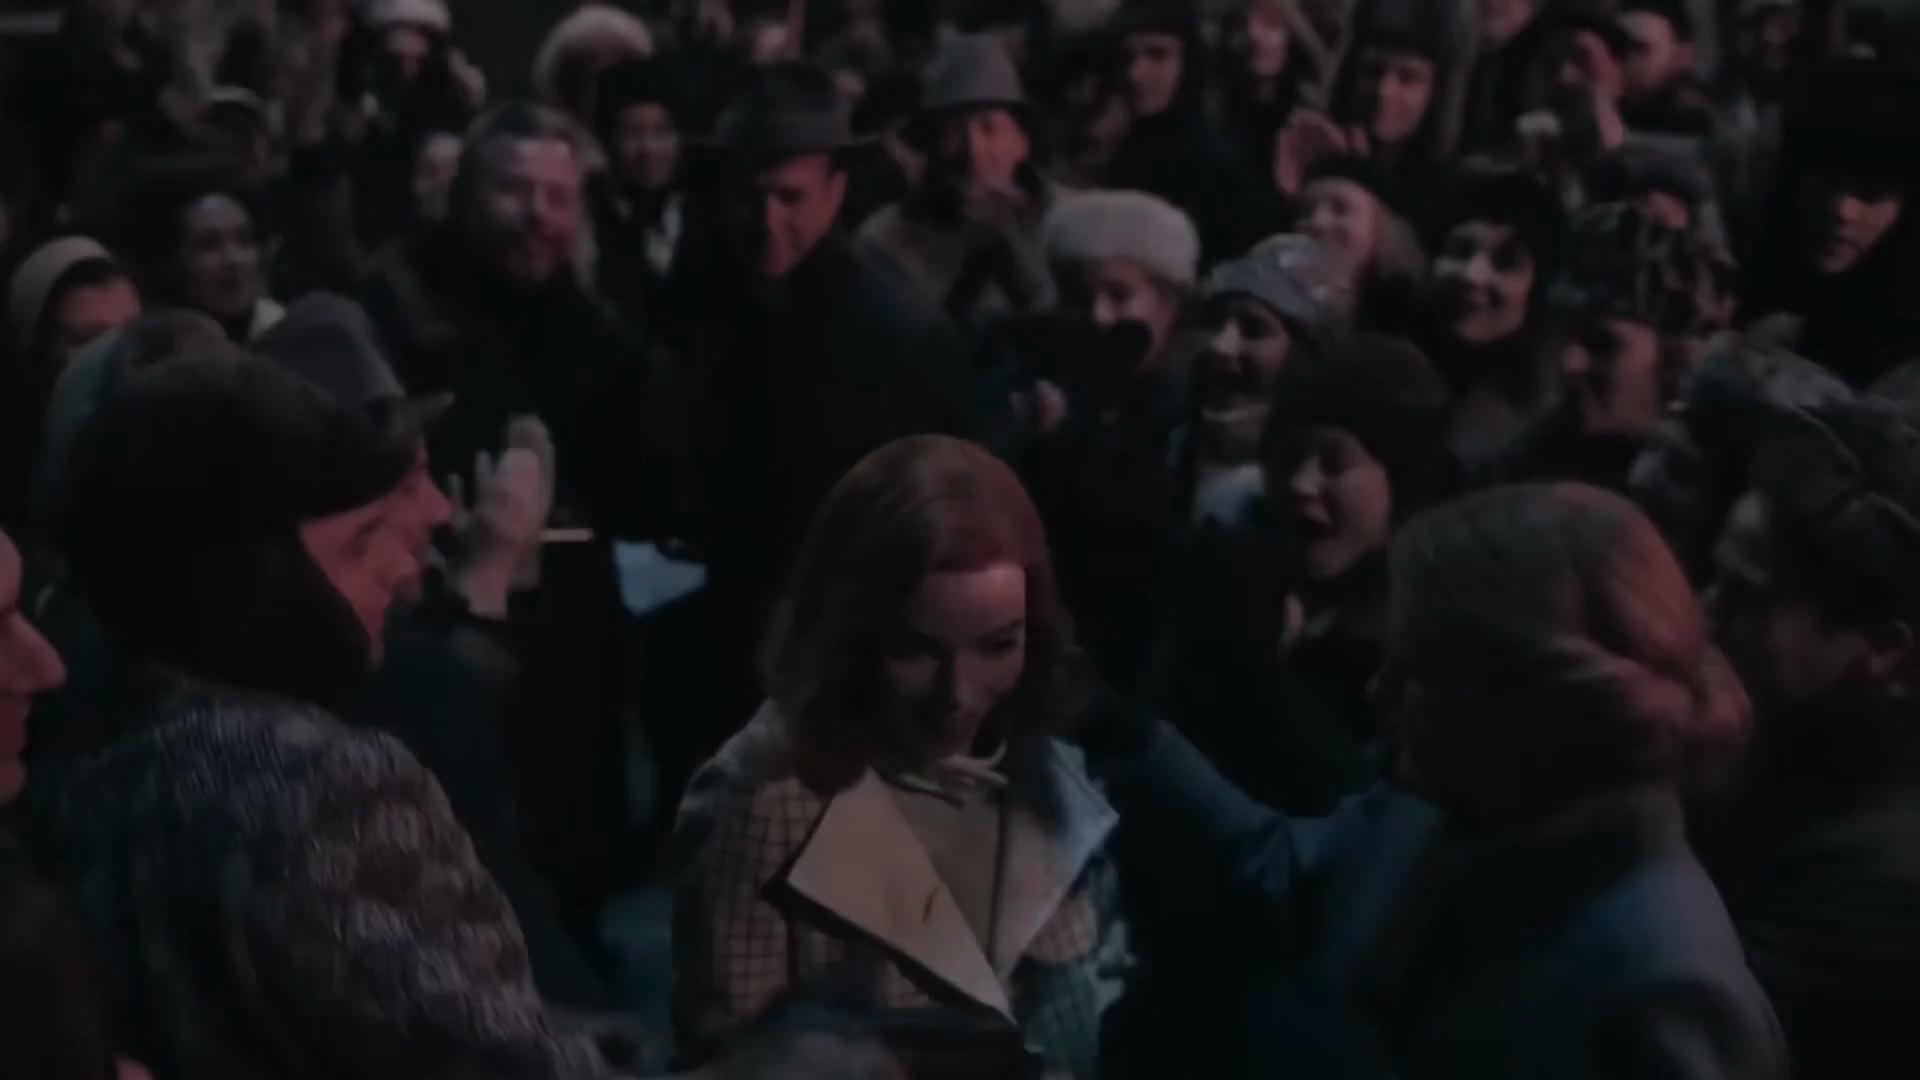

In [12]:
sim_scenes.select(sim_scenes.scene_pos, sim_scenes.middle_frame, sim_scenes.middle_clip).collect()

### More to Explore

- [Embedding Indexes](https://docs.pixeltable.com/platform/embedding-indexes) - for similarity search
- [Video Functions](https://docs.pixeltable.com/sdk/v0.5.0/video) - for `clip()` and `extract_frame()`
- [Tables and Data Operations](https://docs.pixeltable.com/tutorials/tables-and-data-operations) - for creating tables and inserting data
- [Computed Columns](https://docs.pixeltable.com/tutorials/computed-columns) - for adding computed columns

## 02 - Concatenate scene clips into a single reel

Now we'll combine the video clips from our similar scenes into one continuous scene reel.

**Why resize first?** Gemini's video generation model outputs videos at 1280x720 resolution. Since `concat_videos()` requires all videos to have the same resolution, we'll resize our scene clips to 1280x720 now so everything matches when we assemble the final reel (intro + scene reel + outro) in Section 04.

**Steps:**
1. Add resized clips as computed column to sim_scenes
2. Concatenate the resized clips into a single video

**Step 1: Add resized clips as computed column**

We'll add a computed column to `sim_scenes` that resizes the middle clips to 1280x720 using `vid.clip()` to match Gemini's output resolution.

Added 4 column values with 0 errors.


scene_pos                                       resized_clip
0          0  /Users/alison-pxt/.pixeltable/media/474d67ee44...
1          2  /Users/alison-pxt/.pixeltable/media/474d67ee44...
2          4  /Users/alison-pxt/.pixeltable/media/474d67ee44...
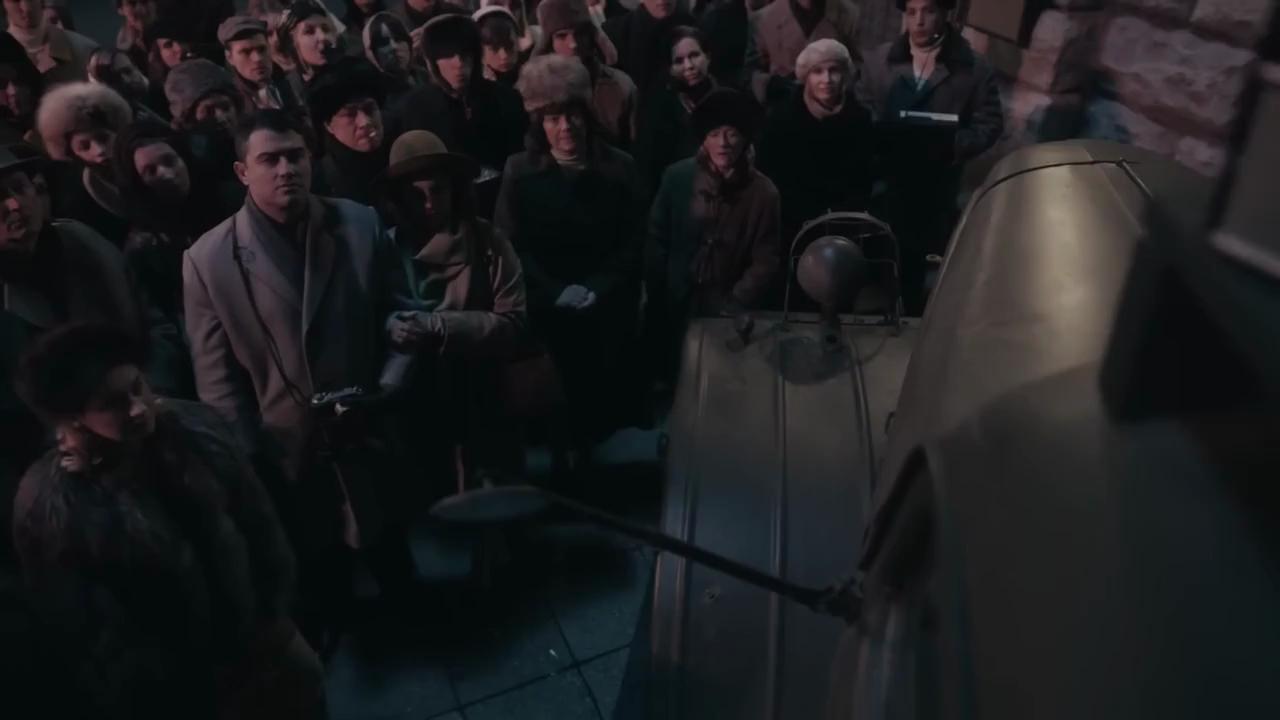
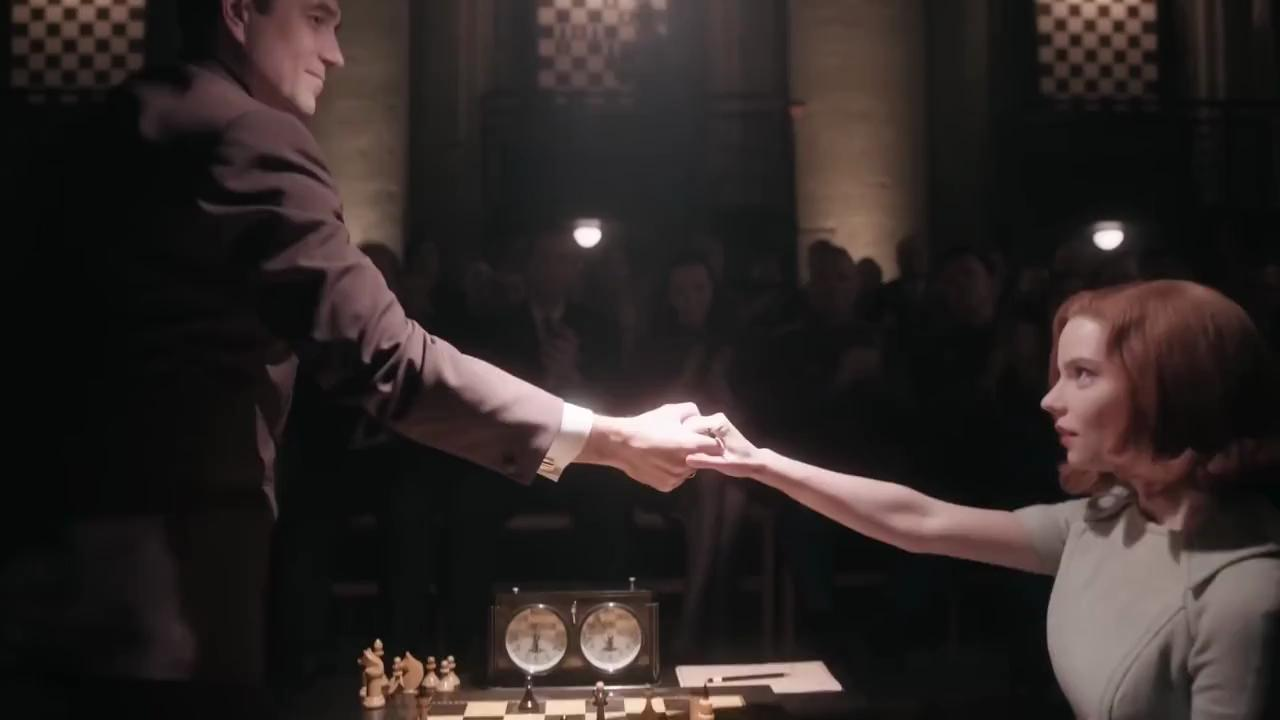
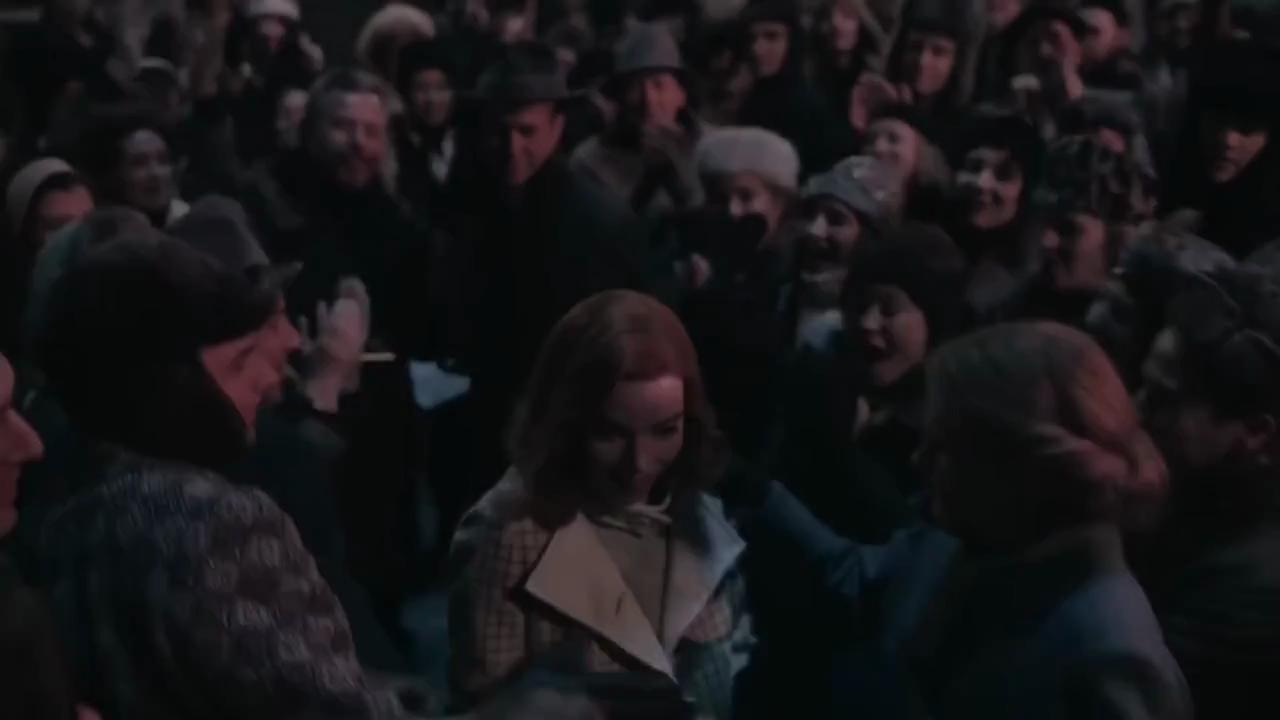

In [13]:
import pixeltable.functions.video as vid

# Add resized_clip as a computed column to sim_scenes
sim_scenes.add_computed_column(
    resized_clip=vid.clip(
        sim_scenes.middle_clip,
        start_time=0,
        video_encoder='libx264',
        video_encoder_args={'vf': 'scale=1280:720'}
    ),
    if_exists='replace'
)

# Preview the resized clips (excluding scene_pos = 5)
clips = sim_scenes.where(sim_scenes.scene_pos != 5).select(sim_scenes.scene_pos, sim_scenes.resized_clip).order_by(sim_scenes.scene_pos).collect()
clips

**Step 2: Concatenate the resized clips**

We'll collect the resized clips (excluding scene_pos = 5), insert them into a table with a Json column, and use `concat_videos()` to combine them into one continuous video.

In [14]:
from pixeltable.functions.video import concat_videos
from pixeltable.functions.uuid import uuid4

# Collect resized clips (excluding scene_pos = 5) for concatenation
resized_clips_list = sim_scenes.where(sim_scenes.scene_pos != 5).select(sim_scenes.resized_clip).order_by(sim_scenes.scene_pos).collect()['resized_clip']

Create scene_reel table with Json column to hold list of videos:

In [15]:
scene_reel = pxt.create_table(
    'scene_reel',
    schema={
        'reel_id': uuid4(),
        'clips': pxt.Json
    },
    if_exists='replace'
)

Created table 'scene_reel'.


In [16]:
scene_reel

table 'scene_reel'

 Column Name            Type Computed With
     reel_id  Required[UUID]       uuid4()
       clips            Json

Insert clips as Json list (list of video file paths)

In [17]:
scene_reel.insert([{'clips': resized_clips_list}])

Inserting rows into `scene_reel`: 1 rows [00:00, 282.71 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 1 value computed.

In [18]:
scene_reel.collect()

reel_id  \
0  6166892b-e072-41ad-9f98-9f058215dd5b   

                                               clips  
0  [/Users/alison-pxt/.pixeltable/media/474d67ee4...

Use concat_videos in computed column on the Json column

In [19]:
scene_reel.add_computed_column(scenes_reel=concat_videos(scene_reel.clips))

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

**View the concatenated scene reel**

The scene_reel table now contains the concatenated video. Let's view it:

scenes_reel
0  /Users/alison-pxt/.pixeltable/media/9dd8b5570e...
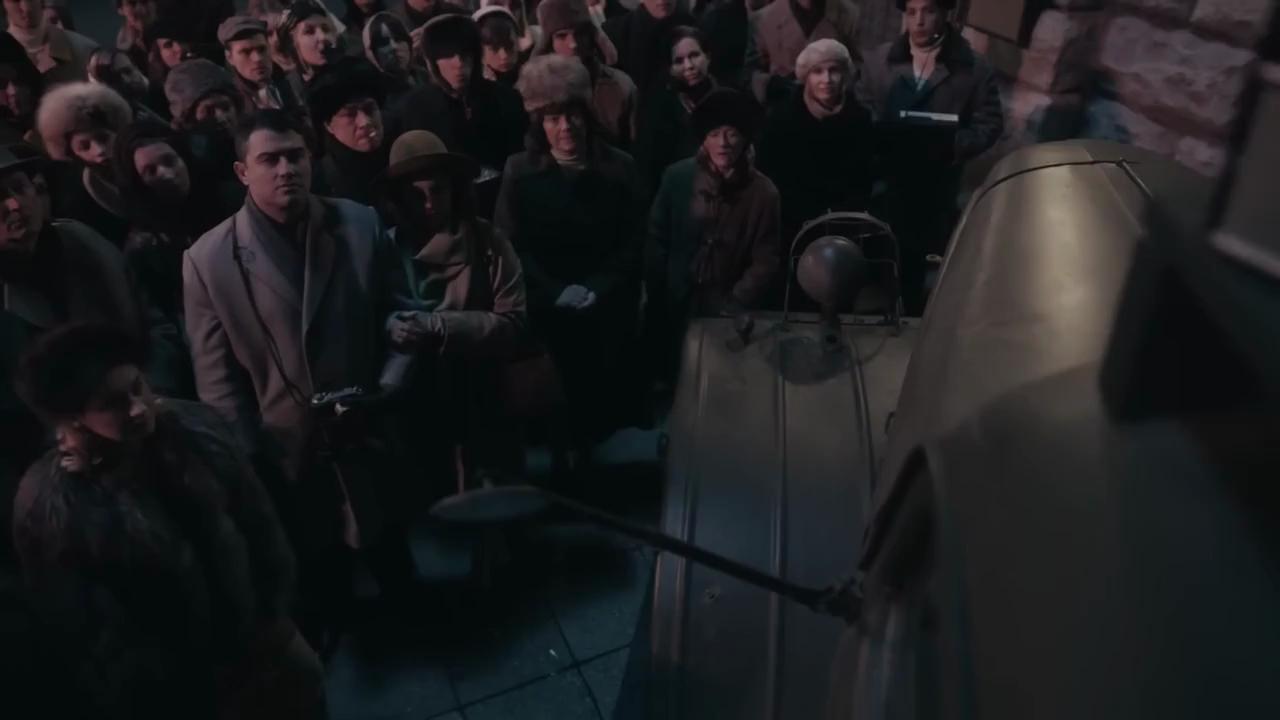

In [20]:
scene_reel.select(scene_reel.scenes_reel).collect()

### More to Explore

- [Video Functions](https://docs.pixeltable.com/sdk/v0.5.0/video) - for `concat_videos()` and video encoding
- [Multimodal Type System](https://docs.pixeltable.com/platform/type-system) - for Json and Video types
- [UUID Identity Cookbook](https://docs.pixeltable.com/howto/cookbooks/core/workflow-uuid-identity) - for using `uuid4()` to generate unique identifiers

## 03 - Generate intro/outro using video model (Gemini)

We'll use Gemini's Veo video generation model to create professional intro and outro videos:
- **Intro**: Image-to-video (animate a static frame)
- **Outro**: Text-to-video (generate from text prompt only)

**Steps:**
1. Extract inspiration frame for intro
2. Create a table to store the frame and prompts
3. Generate intro video from image
4. Generate outro video from text

**Step 1: Extract intro inspiration frame**

Extract a frame from early in the video to use as the basis for our intro animation.

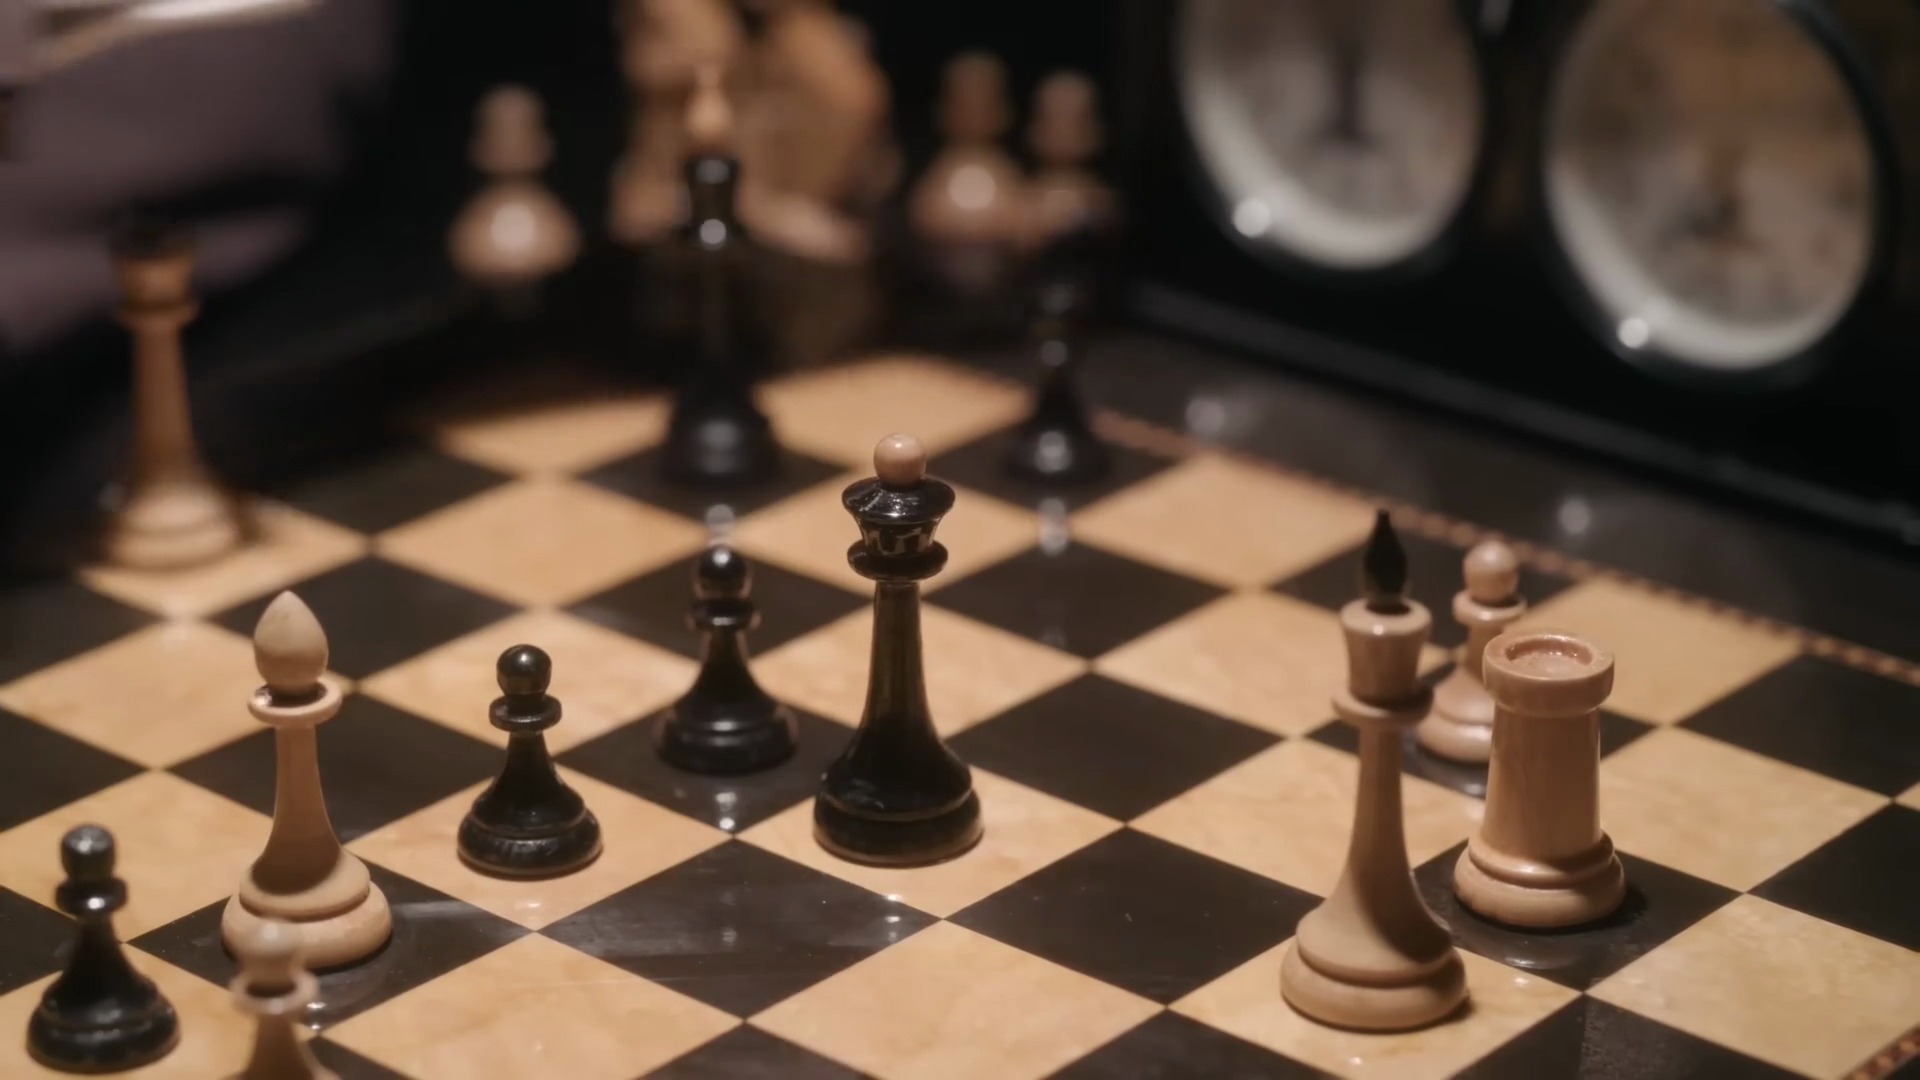

In [21]:
inspo_intro_timestamp = 13  
inspo_intro = scenes.select(
    inspo_intro=scenes.video_segment.extract_frame(timestamp=inspo_intro_timestamp)
).head()[1, 'inspo_intro']
inspo_intro

**Step 2: Create reels table**

Create a table to store our intro inspiration frame and text prompts for both intro and outro video generation.

In [50]:
reels = pxt.create_table(
    'reels',
    schema={
        'inspo_intro': pxt.Image,
        'intro_prompt': pxt.String,
        'outro_prompt': pxt.String
    },
    if_exists='replace'
)

Created table 'reels'.


Insert the intro inspiration frame and text prompts. The intro prompt will guide the image animation, while the outro prompt will generate a video from scratch:

In [51]:
reels.insert([{
    'inspo_intro': inspo_intro,
    'intro_prompt': 'No audio track. Fade in. Camera rises smoothly from ground level to birds eye view, tilting down to look straight at the ground. Scene is frozen in time—nothing moves except the camera.',
    'outro_prompt': 'No audio track. A smooth cinematic fade to black ending sequence that shows only the chess board at its conclusion after a competitive, hard-won match.'
}])

Inserting rows into `reels`: 1 rows [00:00, 351.75 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 4 values computed.

**Step 3: Generate intro video (image-to-video)**

Add a computed column that uses Gemini's `generate_videos()` function to animate the intro frame. The model will create a 4-second video (720p resolution) based on the image and prompt.

In [52]:
from pixeltable.functions import gemini

reels.add_computed_column(
    intro_video=gemini.generate_videos(
        prompt=reels.intro_prompt,
        image=reels.inspo_intro,
        model='veo-3.0-generate-001',
        config={'duration_seconds': 4}
    ),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

In [53]:
reels

table 'reels'

   Column Name             Type                                      Computed With
   inspo_intro            Image                                                   
  intro_prompt           String                                                   
  outro_prompt           String                                                   
   intro_video  Required[Video]  generate_videos(prompt=intro_prompt, image=ins...

View the generated intro video:

intro_video
0  /Users/alison-pxt/.pixeltable/media/8816172100...
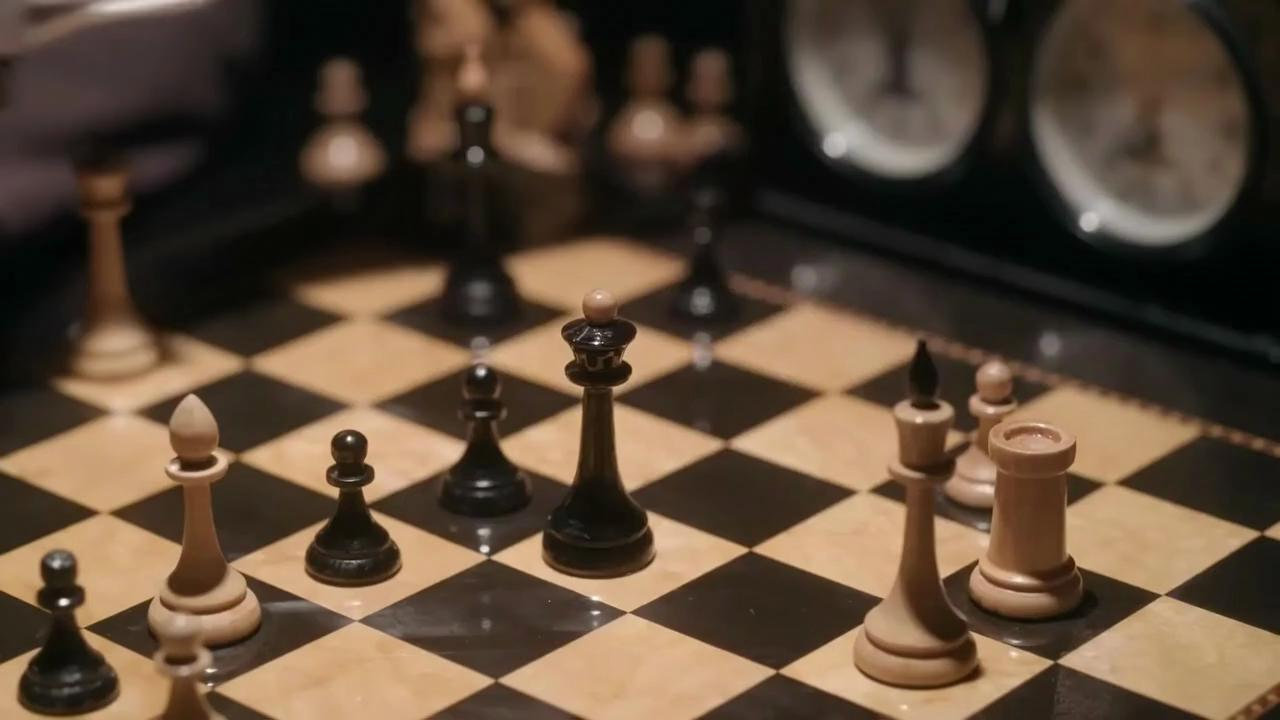

In [54]:
reels.select(reels.intro_video).collect()

**Step 4: Generate outro video (text-to-video)**

Generate the outro video using only a text prompt (no image). This demonstrates Gemini's text-to-video capability:

In [55]:
reels.add_computed_column(
    outro_video=gemini.generate_videos(
        prompt=reels.outro_prompt,
        image=None,
        model='veo-3.0-generate-001',
        config={'duration_seconds': 4}
    ),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

View the generated outro video:

outro_video
0  /Users/alison-pxt/.pixeltable/media/8816172100...
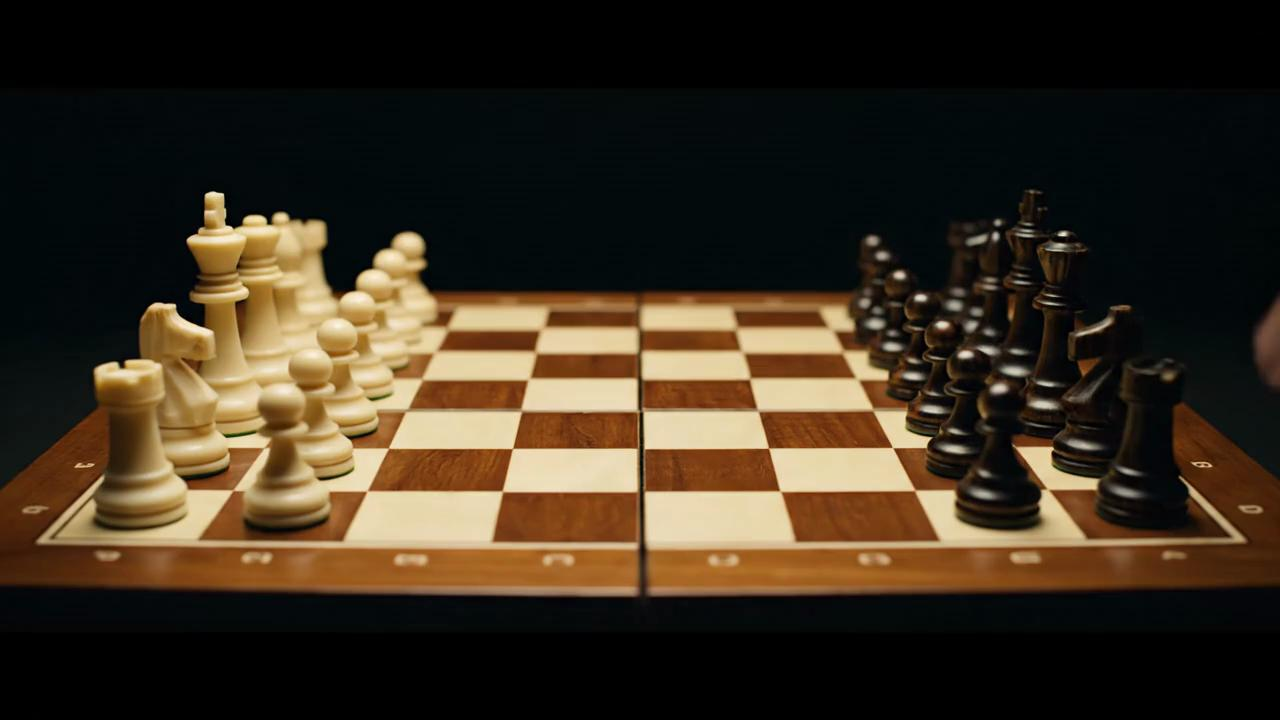

In [56]:
reels.select(reels.outro_video).head()

### More to Explore

- [Working with Gemini](https://docs.pixeltable.com/howto/providers/working-with-gemini) - for `generate_videos()` function
- [Video Functions](https://docs.pixeltable.com/sdk/latest/video) - for `extract_frame()`

## 04 - Assemble the final highlight reel

Now we'll combine all three components into one complete video:
1. **Intro video**: 5-second Gemini-generated animation from image (1280x720)
2. **Scene reel**: Concatenated clips from visually similar scenes (resized to 1280x720)
3. **Outro video**: 5-second Gemini-generated video from text prompt (1280x720)

Since `concat_videos()` requires all videos to have the same resolution, we resized the scene clips to 1280x720 in Section 02.

**Steps:**
1. Create a table to hold all three components
2. Retrieve the videos from their respective tables
3. Insert them into the final reels table
4. Concatenate all three parts using a computed column

**Step 1: Create final reels table**

This table will hold the intro video, scene reel, and outro video as separate columns. 

We'll again use [`uuid4()`](https://pixeltable-dev.mintlify.app/howto/cookbooks/core/workflow-uuid-identity) to automatically generate a unique ID for each final reel—this makes it easy to track and reference specific completed videos in your production system.

In [57]:
final_reels = pxt.create_table(
    'final_reels',
    schema={
        'reel_id': uuid4(),
        'intro_video': pxt.Video,
        'scene_reel': pxt.Video,
        'outro_video': pxt.Video,
        'bg_audio': pxt.Audio
    },
    if_exists='replace'
)

Created table 'final_reels'.


**Step 2: Retrieve the video components**

Pull the intro/outro videos from the `reels` table and the scene reel from the `scene_reel` table:


In [58]:
reels_row = reels.select(reels.intro_video, reels.outro_video).collect()[0]
scene_row = scene_reel.select(scene_reel.scenes_reel).collect()[0]

**Step 3: Insert the components into the final reels table**

Add a row containing all three video components:


In [59]:
final_reels.insert([{
    'intro_video': reels_row['intro_video'],
    'scene_reel': scene_row['scenes_reel'],
    'outro_video': reels_row['outro_video'],
    'bg_audio': 'source/goldberg.mp3'
}])

Inserting rows into `final_reels`: 1 rows [00:00, 355.87 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 9 values computed.

reel_id  \
0  a35668b6-5e77-4418-bc07-806c40635f1a   

                                         intro_video  \
0  /Users/alison-pxt/.pixeltable/media/8816172100...   

                                          scene_reel  \
0  /Users/alison-pxt/.pixeltable/media/9dd8b5570e...   

                                         outro_video  \
0  /Users/alison-pxt/.pixeltable/media/8816172100...   

                                            bg_audio  
0  /Users/alison-pxt/Documents/Github/pxt-primeti...
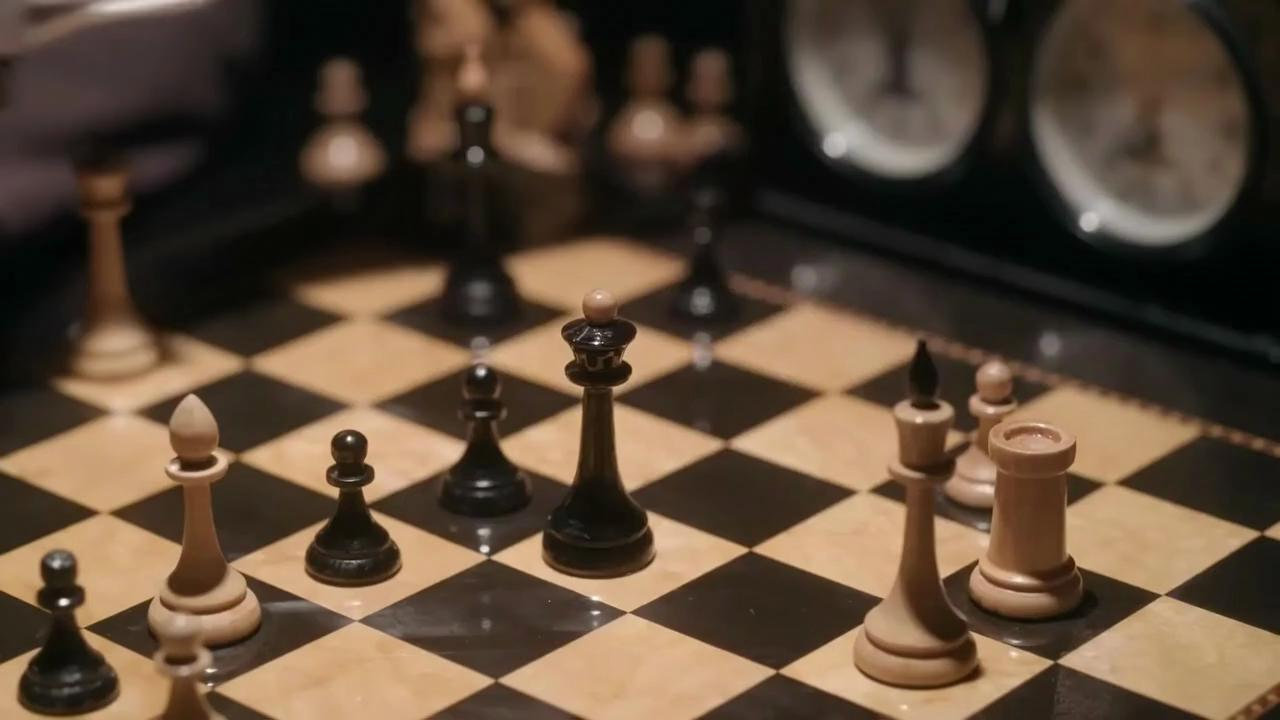
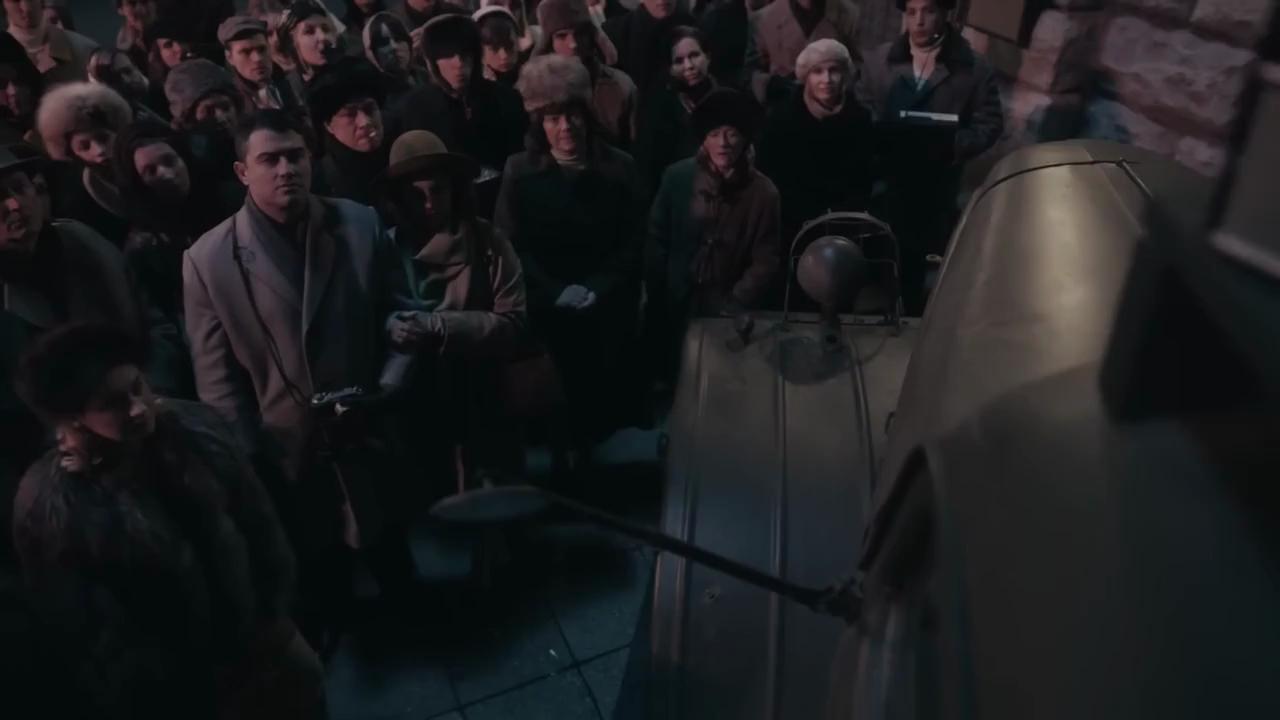
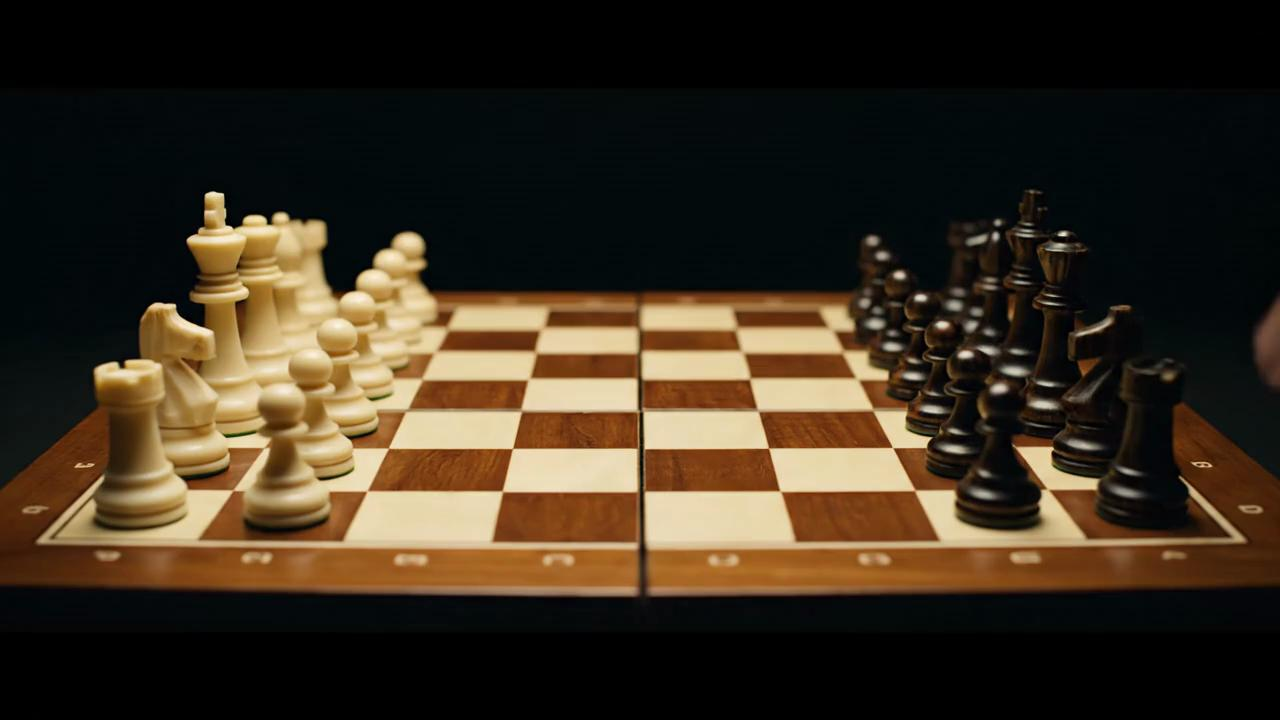

In [60]:
final_reels.collect()

**Step 4: Concatenate all three videos into the final reel**

Add a computed column that concatenates the intro, scene reel, and outro into one complete video. 
We'll use the `destination` parameter to specify where the computed video file should be stored. 
You can use local paths (as shown here) or configure [cloud storage destinations](https://docs.pixeltable.com/integrations/cloud-storage) 
for production deployments:

In [61]:
from pixeltable.functions.video import concat_videos
from pathlib import Path

# Create destination folder on desktop
desktop_path = Path.home() / "Desktop" / "vidz_output"
desktop_path.mkdir(parents=True, exist_ok=True)

# Concatenate intro + scene + outro
final_reels.add_computed_column(
    final_reel=concat_videos(
        [final_reels.intro_video.astype(pxt.String), final_reels.scene_reel.astype(pxt.String), final_reels.outro_video.astype(pxt.String)]
    ),
    destination=str(desktop_path),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

**View the complete final reel**

Now we can view the fully assembled video with intro, scene clips, and outro:


final_reel
0  /Users/alison-pxt/Desktop/vidz_output/5b870115...
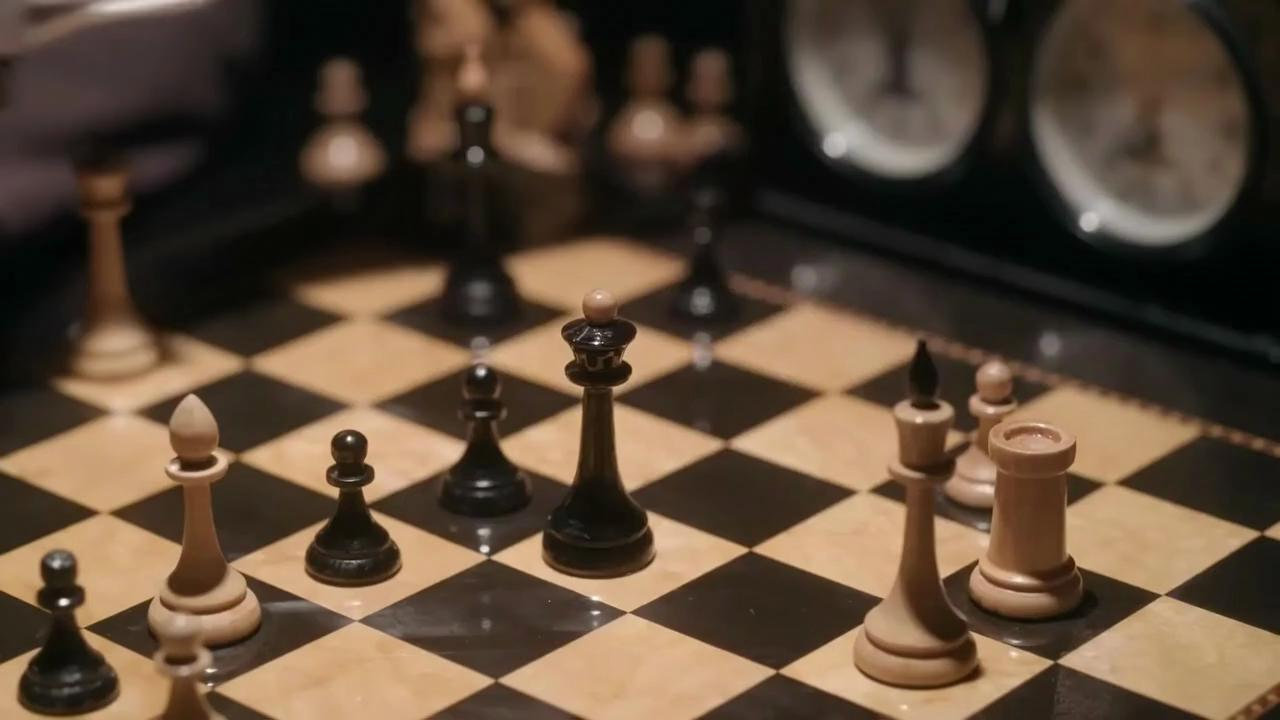

In [62]:
# View the final reel
final_reels.select(final_reels.final_reel).collect()

## 05 - Add audio to the final reel

Now we'll add background music to our final reel using the `with_audio()` function. 
This function combines a video stream with an audio stream to create a new video. 
We'll use the audio file `source/goldberg.mp3` as background music for our final reel.

For more details, see the [with_audio() documentation](https://docs.pixeltable.com/sdk/latest/video#udf-with_audio).


In [63]:
from pixeltable.functions.video import with_audio
from pathlib import Path

# Use the same destination folder as before
desktop_path = Path.home() / "Desktop" / "vidz_output"

# Add audio to the final reel
final_reels.add_computed_column(
    final_reel_with_audio=with_audio(
        video=final_reels.final_reel,
        audio=final_reels.bg_audio
    ),
    destination=str(desktop_path),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

**View the final reel with audio**

Now we can view the final reel with the background music added:


final_reel_with_audio
0  /Users/alison-pxt/Desktop/vidz_output/5b870115...
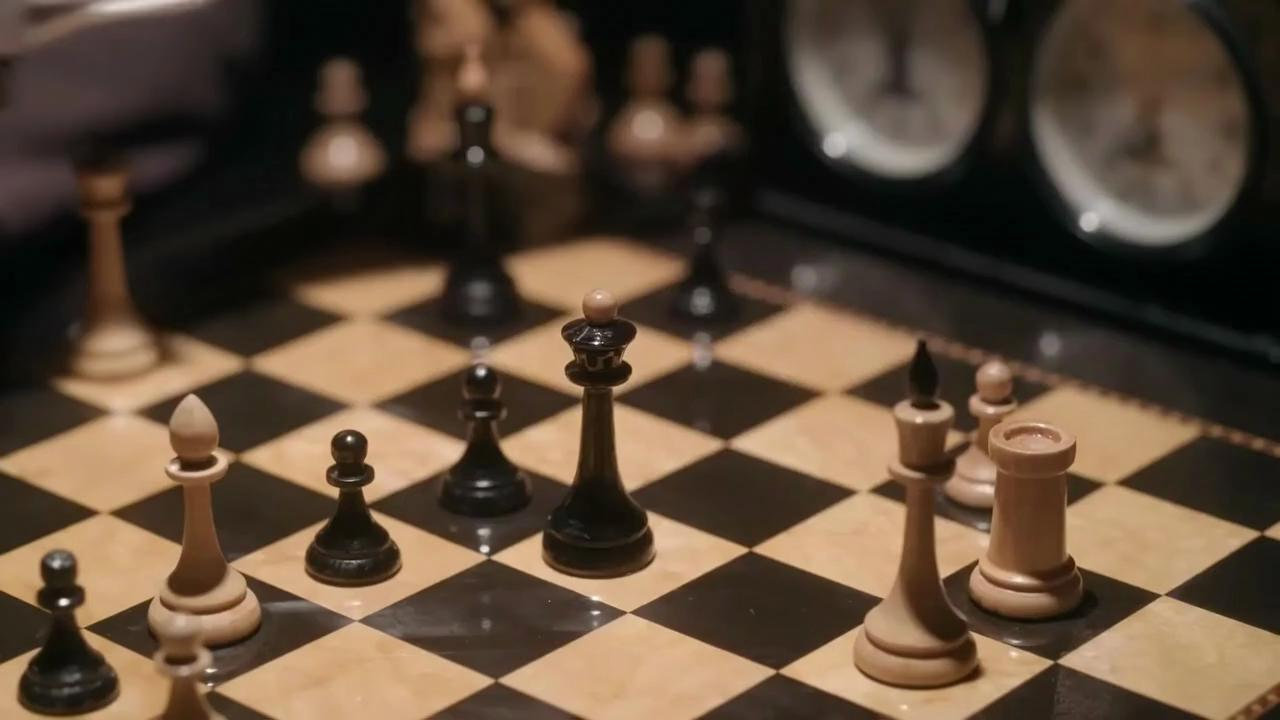

In [64]:
# View the final reel with audio
final_reels.select(final_reels.final_reel_with_audio).collect()

### More to Explore

- [Video Functions](https://docs.pixeltable.com/sdk/latest/video) - for `concat_videos()` 
- [Queries and Expressions](https://docs.pixeltable.com/tutorials/queries-and-expressions) - for querying and retrieving data with `.collect()`
- [Tables and Data Operations](https://docs.pixeltable.com/tutorials/tables-and-data-operations) - for table operations
- [Cloud Storage](https://docs.pixeltable.com/integrations/cloud-storage) - for using the `destination` parameter to specify where computed media files are stored